# Pryngles
## PlanetaRY spanGLES: the bright-side of the light-curve

In [1]:
from pryngles import *

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Jupyter magics

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### External dependencies

In [4]:
import spiceypy as spy
import numpy as np
import scipy as sp
from scipy.optimize import newton
import math
math.arctan=math.atan
math.arcsin=math.asin
math.arccos=math.acos
math.arctan2=math.atan2
from copy import deepcopy
import os
import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d,interp2d
from scipy.integrate import quad,dblquad
import dill

import matplotlib.pyplot as plt
%matplotlib nbagg

# Choose 
#mh=np #Slower but powerful with arrays
mh=math #Faster but not suitable for arrays

### Constants

In [5]:
class Const(object):
    #Astronomical constans
    Rsun=6.95510e8 # meters
    Msun=1.98e30 #kg
    Rsat=5.8232e7 # meters

    #Constants of nature
    au=1.496e11 #meters
    G=6.67e-11 # m^3/(kg*s^2)

    #Time
    hours=3600 # seconds
    days=24*hours # seconds
    yr=365.25*days # seconds

    #Numeric
    deg=mh.pi/180
    rad=1/deg

#Useful macros
RAD=Const.rad
DEG=Const.deg

### Util Class

In [6]:
class Util(object):
    def solveKeplerEquation(M,e):
        """
        Solves Kepler Equation

        Parameters:
            M: Mean anomaly, float [rad]
            e: Eccentricity, float [adim]
         
        Return:
            E: Eccentric anomaly
        """
        return sp.optimize.newton(lambda E:E-e*mh.sin(E)-M,M)

    def convertf2E(f,e):
        """
        From true anomaly to eccentric anomaly

        Parameters:
            f: True anomaly, float [rad]
            e: Eccentricity, float [adim]
         
        Return:
            E: Eccentric anomaly, float [rad]
        """
        return 2*mh.arctan(mh.sqrt((1-e)/(1+e))*mh.tan(f/2))

    def convertE2f(E,e):
        """
        From eccentric anomaly to true anomaly

        Parameters:
            E: Eccentric anomaly, float [rad]
            e: Eccentricity, float [adim]
         
        Return:
            g: True anomaly, float [rad]
        """
        return 2*mh.arctan(mh.sqrt((1+e)/(1-e))*mh.tan(E/2))

    def transformRecLat(rvec):
        """
        Convert from rectangular to sky coordinates (right quadrant)

        Parameters:
            rvec: rectangular coordinates, numpy array (3)
         
        Return:
            longitude: longitude (acimutal angle), float [rad]
            latitude: latitude (elevation angle), float [rad]
        """
        r,long,lat=spy.reclat(rvec)
        long=2*mh.pi+long if long<0 else long
        return long,lat

    def checkAngle(target,center,delta):
        """
        Check if angle target satisfy:  center-delta <= target <= center+delta

        Parameters:
            target: target angle, float [rad]
            center: center angle, float [rad]
            distance: distance angle, float [rad]
            
        Return:
            condition: true if condition is satisfied, boolean.
        """
        dot=np.cos(center)*np.cos(target)+np.sin(center)*np.sin(target)
        sep=np.arccos(dot)
        return sep<=delta
    
    def difAngles(angle1,angle2):
        """
        Compute the minimum difference between two angles.        
        
        Parameters:
            angle1,angle2: angles, float [rad]
            
        Return:
            difference: angle1-angle2, float [rad]
        """
        try:
            return mh.arctan2(mh.sin(angle1-angle2),mh.cos(angle1-angle2))
        except:
            return np.arctan2(np.sin(angle1-angle2),np.cos(angle1-angle2))

    def transfromLoc2Equ(r,Ra=1,Rb=1,Rc=1):
        """
        Generate transformation matrices to going from local coordinates (referred to horizon of a point in a body)
        to equatorial coordinates (referred to equator of the body)

        Parameters:
            r {equ}: position of the point on the surface, numpy array (3)
            
        Options:
            Ra=1: Equatorial radius in the direction of the x-axis, float [cu]
            Rb=1: Equatorial radius in the direction of the y-axis, float [cu]
            Rc=1: Polar radius, float [cu]

        Return:
            M_loc2equ, M_equ2loc: transform from local to equatorial and viceversa, 
            numpy matrix (3x3)
        """
        if (Ra+Rb)!=2*Rc:
            uz=spy.surfnm(Ra,Rb,Rc,r)
        else:
            uz=r/spy.vnorm(r)
        uy=np.array([-uz[1],+uz[0],0])/(uz[0]**2+uz[1]**2)**0.5 # uy = [0,0,1] x uz / |uy|
        ux=spy.ucrss(uz,uy)
        M_loc2equ=np.array(np.vstack((ux,uy,uz)).transpose().tolist())
        M_equ2loc=spy.invert(M_loc2equ)
        return M_loc2equ,M_equ2loc

    def transformLoc2EquSpherical(r,R=1):
        """
        Generate transformation matrices to going from local coordinates (referred to horizon of a point in a body)
        to equatorial coordinates (referred to equator of the body)

        Parameters:
            r {equ}: position of the point on the surface, numpy array (3)

        Options:
            R=1: Radius of the planet, float [cu]

        Return:
            M_loc2equ, M_equ2loc: transform from local to equatorial and viceversa, 
            numpy matrix (3x3)
            
        Test:
            rps=array([ 0.44264092, -0.8924685 ,  0.087     ])
            Mx[1,0,0] = (array([-0.03865633,  0.07794028,  0.99620831]),
            Mx[0,1,0] = array([0.89586534, 0.44432566, 0.        ]),
            Mx[0,0,1] = array([ 0.44264092, -0.8924685 ,  0.087     ]))        
        """
        uz,rnorm=spy.unorm(r)
        uy=np.array([-uz[1],+uz[0],0])/(uz[0]**2+uz[1]**2)**0.5 
        ux=spy.ucrss(uz,uy)
        M_loc2equ=np.array(np.vstack((ux,uy,uz)).transpose().tolist())
        M_equ2loc=spy.invert(M_loc2equ)
        return M_loc2equ,M_equ2loc
    
    def calcAngularDistance(pos1,pos2):
        """
        Angular distance from pos1:(lon1,lat1) to pos2:(lon2,lat2) using Haversine
        
        Parameters:
            pos1, pos2: [longitude,latitude], tuple|list|numpy array (2) [rad] 
         
        Return:
            distance: angular distance, float [rad]

        """
        lon1,lat1=pos1
        lon2,lat2=pos2
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = mh.sin(dlat/2)**2 + mh.cos(lat1) * mh.cos(lat2) * mh.sin(dlon/2) **2
        c = 2 * mh.arctan2(a**0.5, (1-a)**0.5)
        return c
    
    def limbDarkeningNormalization(cs=[0.6562]):
        integrand=lambda rho:Util.limbDarkening(rho,1,cs)*2*mh.pi*rho
        N=quad(integrand,0.0,1.0,epsrel=1e-5)[0]
        return N
    
    def limbDarkening(rho,Rs=1,cs=[0.6562],N=1):
        """
        Notes: 
            Models in: https://pages.jh.edu/~dsing3/David_Sing/Limb_Darkening.html
            Coefficients available at: https://pages.jh.edu/~dsing3/LDfiles/LDCs.CoRot.Table1.txt

        Test code:
            fig=plt.figure()
            ax=fig.gca()
            rhos=np.linspace(0,1,100)
            Rs=1
            coefs=[0.6550]
            N=Util.limbDarkeningNormalization(coefs)
            ax.plot(rhos,Util.limbDarkening(rhos,Rs,coefs,N))
            coefs=[0.6022,0.0654]
            N=Util.limbDarkeningNormalization(coefs)
            ax.plot(rhos,Util.limbDarkening(rhos,Rs,coefs,N))
            coefs=[0.9724,-0.4962,0.2029]
            N=Util.limbDarkeningNormalization(coefs)
            ax.plot(rhos,Util.limbDarkening(rhos,Rs,coefs,N))        
        """
        mu=(1-rho**2/Rs**2)**0.5
        order=len(cs)
        if order==0:
            I=np.ones_like(rho)
        elif order==1:
            I=1-cs[0]*(1-mu)
        elif order==2:
            I=1-cs[0]*(1-mu)-cs[1]*(1-mu)**2
        elif order==3:
            I=1-cs[0]*(1-mu)-cs[1]*(1-mu**1.5)-cs[2]*(1-mu**2)
        else:
            raise ValueError(f"Limb darkening not implemented for order {order}")
        return I/N
    
    def saveObject(obj,objfile):
        dill.dump(obj,open(objfile,"wb"))

    def loadObject(objfile):
        obj=dill.load(open(objfile,"rb"))
        return obj
    
    def divArray(a,b,default=0):
        """
        Divide two arrays
        
        Parameters:
            a,b: arrays, numpy arrays.
            
        Optional parameters:
            default=0: default value to return when b=0.
            
        Return: 
            d: result of dividing a/b.  If b is zero the value returned is default.
        """
        return np.divide(a,b,out=default*np.ones_like(b),where=(b!=0))
    
    def attenuationFactor(mu,taug,diffraction=True):
        """
        Compute the attenuation factor of diffusely transmitted flux by a plane parallel layer of 
        particles with geometrical opacity taug and single scattering albedo wo=0.5 (only diffraction).

        Parameters:
            mu: cosine of the incident angle.  mu=1 when incidence is normal and 0 when is surficial, 
                numpy array.
            taug: geometrical 
            
        Optional parameters:
            diffraction=True: include diffraction?, bool
            
        Return:
            factor: attenuation factor 1/mu*exp(-2*taug/mu) if including diffraction, or simply exp(-2*taug/mu),
                    numpy array

        Examples:
            %timeit Util.attenuationFactor(betas,taug,False)
        
            fig=plt.figure()
            ax=fig.gca()
            taug=1.0
            ax.plot(betas,Util.attenuationFactor(betas,taug),label='With diffraction')
            ax.plot(betas,Util.attenuationFactor(betas,taug,False),label='No diffracion')
            ax.legend()            

        Notes:
            Taken from French & Nicholson (2000), Eq. (7)
        """
        argument=Util.divArray(taug,np.array(mu),default=1e100)
        if diffraction:
            return argument*np.exp(-2*argument)
        else:
            return np.exp(-2*argument)
    
    def setAxis2dEqual(ax,values=(),margin=0,xcm=None,ycm=None,xmin=None,ymin=None):
        """
        Set axis to equal aspect ratio.
        
        Parameters:
            ax: axis to set, matplotlib axis.
            values: values represented, tuple, list or numpy array.
            
        Optional parameters:
            margin=0: margin between plot and border, same units as values, float.
            xcm=0,ycm=0: position of the center of the plot, float.
            xmin=None, ymin=None: minimum values of abcisa and ordinate, float. 
         
        Return:
            None

        """
        #values
        vals=np.array([])
        for value in values:
            vals=np.append(vals,np.array(value).flatten())
        #Center of values
        rcm=vals.mean()
        vals=vals-rcm

        if xcm is None:
            xcm=rcm
        if ycm is None:
            ycm=rcm

        fig=ax.figure
        bbox=ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        width,height=bbox.width,bbox.height
        fx=width/height
        fy=1
        if fx<1:
            factor=fy
            fy=(1+margin)*1/fx
            fx=(1+margin)*factor
        else:
            fx*=(1+margin)
            fy*=(1+margin)

        max_value=np.abs(vals).max()
        ax.set_xlim((xcm-fx*max_value,xcm+fx*max_value))
        ax.set_ylim((ycm-fy*max_value,ycm+fy*max_value))

        if xmin is not None:
            xinf,xsup=ax.get_xlim()
            dx=xsup-xinf
            ax.set_xlim((xmin,xmin+dx))

        if ymin is not None:
            yinf,ysup=ax.get_ylim()
            dy=ysup-yinf
            ax.set_ylim((ymin,ymin+dy))
            
    def calcRingedPlanetArea(Rp,fi,fe,ir,beta=1):
        """
        Compute the projected ringed planet area.
        
        Parameters:
            Rp: Planetary radius, float [Rs, stellar radius]
            fi: Inner ring border radius, float [Rp]
            fe: Outer ring border radius, float [Rp]
            ir: Effective inclination of the ring (pi/2 for an edge on ring), float [rad]
            
        Return:
            delta: projected ring area, float [As, stella area]
            
        Notes:
            Taken from Zuluaga et al. (2015)
        """        
        #AUXILIAR VARIABLES
        cosir=np.cos(ir)
        sinir=np.sin(ir)

        #INTERNAL RING EFFECTIVE RADIUS
        if fi*cosir>1:
            ri2=fi**2*cosir-1
        else:
            yi=np.sqrt(fi**2-1)/(fi*sinir)
            ri2=fi**2*cosir*2/np.pi*np.arcsin(yi)-\
                2/np.pi*np.arcsin(yi*fi*cosir)
        ri2=beta*ri2

        #EXTERNAL RING EFFECTIVE RADIUS
        if fe*cosir>1:
            re2=fe**2*cosir-1
        else:
            ye=np.sqrt(fe**2-1)/(fe*sinir)
            re2=fe**2*cosir*2/np.pi*np.arcsin(ye)-\
                2/np.pi*np.arcsin(ye*fe*cosir)
        re2=beta*re2

        #RINGED-PLANET AREA
        ARp=np.pi*Rp**2+np.pi*(re2-ri2)*Rp**2

        return ARp

### Configuration

In [7]:
class Conf(object):
    FIGDIR="./paper2-model/figures/"

### Units

In [8]:
class CanonicalUnits(object):
    def __init__(self,UL=0,UT=0,UM=0):
        if (UL==0)+(UT==0)+(UM==0)!=1:
            raise AssertionError("You should provide at least two units.")
        if (UL==0):
            self.UM=UM
            self.UT=UT
            self.UL=(Const.G*UM*UT)**(1./3)
        elif (UT==0):
            self.UM=UM
            self.UL=UL
            self.UT=(UL**3/(Const.G*UM))**0.5
        elif (UM==0):
            self.UL=UL
            self.UT=UT
            self.UM=(UL**3/(Const.G*UT))**0.5

        #Derived units
        self.UV=self.UL/self.UT #Velocity
        self.UA=self.UL/self.UT**2 #Velocity
        self.UP=self.UM*self.UV #Linear momentum
        self.UAM=self.UL*self.UP #Angular momentum
        self.UF=self.UM*self.UA #Force
        self.UE=self.UF*self.UA #Energy
        self.UN=1/self.UT #Angular frequency

### Sampling class

In [9]:
class Sample(object):
    """
    Fibonacci sampling of disks, hemispheres and spheres.
    
    Initialization attributes:
        N: Number of samples, int.
        
    Optional attibutes:
        seed=0: Value of the integer seed of random number generation (if 0 no random seed is set), int.
        
    Secondary attributes:
        dim: Dimension of samples, int.
        ss: Samples in cartesian coordinates, numpy array (Nx3)
        pp: Samples in polar or spherical coordinates (r,phi,theta), numpy array (Nx3)
            Where phi is azimutal angle and theta is elevation (complement of polar angle).
        dmin, dmed, dmax: Minimum, median and maximum distance between sampling points, float
        ds: minimum distances of all points, numpy array (N)
        dran: range of distances (dmax-dmin), float
        dstar: measure of distances (sqrt(N)*dmed), float
               Typically this value is between 2.4 and 3.4.
               
        Plot:
        
            cargs=dict(color="k",fill=False,alpha=0.3): 
                arguments for plotting the circumference in polar, dictionary.
                   
            wargs=dict(color="k",lw=0.1): 
                arguments for plotting sphere in 3d space, dictionary.
        
    Private attributes:
        _purge=True : Does the sample need to be purged?, boolean
        
    Notes:
        This module is based on fibpy by Martin Roberts, source code: https://github.com/matt77hias/fibpy
    """
    def __init__(self,N,seed=0):
        #Basic
        self.N=N
        
        #Derivative
        self.dim=0
        self.ss=None
        self.pp=None
        self.dmin=self.dmed=self.dmax=0
        
        #Purge
        self._purge=True
        
        #Plotting
        self.cargs=dict(color="k",fill=False,alpha=0.3)
        self.wargs=dict(color="k",lw=0.1)
        
        #Random seed
        if seed:
            np.random.seed(seed)
    
    def _closestDistance(self,r,rs):
        """
        Get the minimum distance from point p to other points
        
        Parameter:
            r: coordinates of the point, numpy array (3)
            rs: coordinates of the points, numpy array (N)
        
        Return:
            dmin: minimum distance, float
        """
        deltas=rs-r
        dist=np.einsum('ij,ij->i',deltas,deltas)
        imin=np.argsort(dist)[1]
        return np.sqrt(dist[imin])

    def _calcDistances(self):
        """
        Calculate the minimum distances of all points in the sample.
        
        Update:
            ds,dmin,dmax,dmed,dran,dstar.
        """
        self.ds=np.array([self._closestDistance(self.ss[i],self.ss) for i in range(len(self.ss))])
        self.dmin=self.ds.min()
        self.dmax=self.ds.max()
        self.dmed=np.median(self.ds)
        self.dran=self.dmax-self.dmin
        self.dstar=np.sqrt(self.N)*self.dmed
    
    def purgeSample(self,tol=0.5):
        """
        Purge sample, ie. remove points close than a given threshold.
        
        Optional parameters:
            tol: distance to purge, ie. if dmin<tol*dmed then purge, float
            
        Update:
            ss, pp, N, _purge
        """
        while self._purge:
            self._calcDistances()
            if self.dmin<tol*self.dmed:
                ipurge=np.argsort(self.ds)[0]
                self.ss=np.delete(self.ss,ipurge,0)
                self.pp=np.delete(self.pp,ipurge,0)
                self.N-=1
            else:
                self._purge=False
            
    def genUnitCircle(self,perturbation=1,boundary=2):
        """
        Sample points in fibonacci spiral on the unit circle
        
        Optional parameters:
            perturbation: type of perturbation (0 normal perturbation, 1 random perturbation), int
            boundary: type of boundary (0 jagged, >1 smooth)
            
        Update:
            ss, pp
        """
        shift = 1.0 if perturbation == 0 else self.N*np.random.random()

        ga = np.pi * (3.0 - np.sqrt(5.0))

        # Boundary points
        np_boundary = round(boundary * np.sqrt(self.N))

        self.dim=2
        self.ss = np.zeros((self.N,self.dim))
        self.pp = np.zeros((self.N,self.dim))
        j = 0
        for i in range(self.N):
            if i > self.N - (np_boundary + 1):
                r = 1.0
            else:
                r = np.sqrt((i + 0.5) / (self.N - 0.5 * (np_boundary + 1)))
            phi   = ga * (i + shift)
            self.ss[j,:] = np.array([r * np.cos(phi), r * np.sin(phi)])
            self.pp[j,:] = np.array([r,np.mod(phi,2*np.pi)])
            j += 1

    def genUnitCircleWithGaps(self,gaps,perturbation=1,boundary=2):
        """
        Sample points in fibonacci spiral on the unit circle, but including gaps (as in rings)
        
        Parameters:
            gaps: description of the position of gaps in the form [(R1,dR1),(R2,dR2),...], List of tuples.
        
        Optional parameters:
            perturbation: type of perturbation (0 normal perturbation, 1 random perturbation), int
            boundary: type of boundary (0 jagged, >1 smooth)
            
        Example:
            s.Sample(1000)
            s.genUnitCircleWithGaps([(0,0.2),(0.5,0.2),[0.8,0.1]])
            
        Update:
            ss, pp
        """
        shift = 1.0 if perturbation == 0 else self.N*np.random.random()
        ga = np.pi * (3.0 - np.sqrt(5.0))

        self.dim=2
        Ntest = self.N
        Nacc = 0

        while Nacc < self.N:        

            # Boundary points
            np_boundary = round(boundary * np.sqrt(Ntest))

            ss = []
            pp = []
            j = 0
            for i in range(Ntest):
                if i > Ntest - (np_boundary + 1):
                    r = 1.0
                else:
                    r = np.sqrt((i + 0.5) / (Ntest - 0.5 * (np_boundary + 1)))

                skip = False
                for gap in gaps:
                    if gap[0]<=r<=(gap[0]+gap[1]):
                        skip = True
                if skip:continue

                phi   = ga * (i + shift)
                ss += [np.array([r * np.cos(phi), r * np.sin(phi)])]
                pp += [np.array([r,np.mod(phi,2*np.pi)])]
                j += 1
            Nacc = j
            Ntest += int((Ntest-Nacc)/len(gaps))
            
        self.ss=np.array(ss)
        self.pp=np.array(pp)
        self.N=Nacc

    def genUnitHemisphere(self,perturbation=1,up=True):
        """
        Sample points in the unit hemisphere following fibonacci spiral
        
        Optional parameters:
            perturbation: type of perturbation (0 normal perturbation, 1 random perturbation), int
            up: side of hemisphere (True for upper hemisphere), boolean
            
        Update:
            ss, pp
        """
        n = 2 * self.N
        rn = range(self.N,n) if up else range(self.N) 

        shift = 1.0 if perturbation == 0 else n * np.random.random()

        ga = np.pi * (3.0 - np.sqrt(5.0))
        offset = 1.0 / self.N

        self.dim=3
        self.ss = np.zeros((self.N,self.dim))
        self.pp = np.zeros((self.N,self.dim))
        j = 0
        for i in rn:
            phi   = ga * ((i + shift) % n)
            cos_phi = np.cos(phi)
            sin_phi = np.sin(phi)
            cos_theta = ((i + 0.5) * offset) - 1.0
            theta=np.arccos(cos_theta)
            sin_theta = np.sqrt(1.0 - cos_theta*cos_theta)
            self.ss[j,:] = np.array([cos_phi * sin_theta, sin_phi * sin_theta, cos_theta])
            self.pp[j,:] = np.array([1,np.mod(phi,2*np.pi),np.pi/2-theta])
            j += 1

    def genUnitSphere(self,perturbation=1):
        """
        Sample points in the unit sphere following fibonacci spiral
        
        Optional parameters:
            perturbation: type of perturbation (0 normal perturbation, 1 random perturbation), int
            
        Update:
            ss, pp
        """

        shift = 1.0 if perturbation == 0 else self.N * np.random.random()

        ga = np.pi * (3.0 - np.sqrt(5.0))
        offset = 2.0 / self.N
        
        self.dim=3
        self.ss = np.zeros((self.N,self.dim))
        self.pp = np.zeros((self.N,self.dim))
        j = 0
        for i in range(self.N):
            phi   = ga * ((i + shift) % self.N)
            cos_phi = np.cos(phi)
            sin_phi = np.sin(phi)
            cos_theta = ((i + 0.5) * offset) - 1.0
            sin_theta = np.sqrt(1.0 - cos_theta*cos_theta)
            theta=np.arccos(cos_theta)            
            self.ss[j,:] = np.array([cos_phi * sin_theta, sin_phi * sin_theta, cos_theta])
            self.pp[j,:] = np.array([1,np.mod(phi,2*np.pi),np.pi/2-theta])
            j += 1

    def genCosineWeightedUnitHemisphere(self,perturbation=1):
        """
        Sample points in the unit hemisphere (with density weighted accordiging to cosine of colatitude)
        following fibonacci spiral
        
        Optional parameters:
            perturbation: type of perturbation (0 normal perturbation, 1 random perturbation), int
            
        Update:
            ss, pp
        """

        shift = 1.0 if perturbation == 0 else self.N * np.random.random()

        ga = np.pi * (3.0 - np.sqrt(5.0))

        self.dim=3
        self.ss = np.zeros((self.N,self.dim))
        self.pp = np.zeros((self.N,self.dim))
        j = 0
        for i in range(self.N):
            sin_theta = np.sqrt((i + 0.5) / (self.N - 0.5))
            cos_theta = np.sqrt(1.0 - sin_theta*sin_theta)
            phi   = ga * (i + shift)
            cos_phi = np.cos(phi)
            sin_phi = np.sin(phi)
            theta=np.arccos(cos_theta)                        
            self.ss[j,:] = np.array([cos_phi * sin_theta, sin_phi * sin_theta, cos_theta])
            self.pp[j,:] = np.array([1,np.mod(phi,2*np.pi),np.pi/2-theta])
            j += 1
    
    def _setEqualAspectRatio2D(self,xs,ys,alpha=1.5,delta=0.0):
        """
        Make axes of plot2d equal
        
        Parameters:
            xs,ys: Points to be plotted, numpy array (Nx2)
            alpha: Factor, float.
            delta: Distance, float.
            
        Update:
            ax
        """
        self.ax.set_aspect('equal')
        mn = np.array([xs.min(), ys.min()])
        mx = np.array([xs.max(), ys.max()])
        d = 0.5 * (mx - mn)
        c = mn + d
        d = alpha * np.max(d) + delta

        self.ax.set_xlim(c[0] - d, c[0] + d)
        self.ax.set_ylim(c[1] - d, c[1] + d)
        
    def _set_axes3d_equal(self):
        '''
        Make axes of 3D plot have equal scale so that spheres appear as spheres,
        cubes as cubes, etc..  This is one possible solution to Matplotlib's
        ax.set_aspect('equal') and ax.axis('equal') not working for 3D.
        '''
        ax=self.ax
        x_limits = ax.get_xlim3d()
        y_limits = ax.get_ylim3d()
        z_limits = ax.get_zlim3d()
        
        x_range = abs(x_limits[1] - x_limits[0])
        x_middle = np.mean(x_limits)
        y_range = abs(y_limits[1] - y_limits[0])
        y_middle = np.mean(y_limits)
        z_range = abs(z_limits[1] - z_limits[0])
        z_middle = np.mean(z_limits)
        
        # The plot bounding box is a sphere in the sense of the infinity
        # norm, hence I call half the max range the plot radius.
        plot_radius = 0.5*max([x_range, y_range, z_range])
        
        ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
        ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
        ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])
        
    def _setEqualAspectRatio3D(self,xs,ys,zs,alpha=1.5,delta=0.0):
        """
        Parameters:
            xs,ys: Points to be plotted, numpy array (Nx2)
            alpha: Factor, float.
            delta: Distance, float.
            
        Update:
            ax
        """
        #Not yet implemented in matplotlib
        #self.ax.set_aspect('equal')
        
        mn = np.array([xs.min(), ys.min(), zs.min()])
        mx = np.array([xs.max(), ys.max(), zs.max()])
        d = 0.5 * (mx - mn)
        c = mn + d
        d = alpha * np.max(d) + delta

        self.ax.set_xlim(c[0] - d, c[0] + d)
        self.ax.set_ylim(c[1] - d, c[1] + d)
        self.ax.set_zlim(c[2] - d, c[2] + d)

        self._set_axes3d_equal()

    def plotSample(self,**args):
        """
        Plot sample.
        
        Parameters:
            args: scatter plotting options, dictionary.
        """
        sargs=dict(c='k',s=1.5)
        sargs.update(args)
        if self.dim==2:            
            self.fig,self.ax=plt.subplots(1,1)
            self.ax.scatter(self.ss[:,0],self.ss[:,1],**sargs)
            self.ax.add_patch(plt.Circle((0,0),1,**self.cargs))
            self._setEqualAspectRatio2D(self.ss[:,0],self.ss[:,1])
        else:
            self.fig=plt.figure()
            self.ax=plt.gca(projection='3d')
            self.ax.scatter(self.ss[:,0],self.ss[:,1],self.ss[:,2],**sargs)
            u,v=np.mgrid[0:2*np.pi:20j,0:np.pi:10j]
            x=np.cos(u)*np.sin(v)
            y=np.sin(u)*np.sin(v)
            z=np.cos(v)
            self.ax.plot_wireframe(x,y,z,**self.wargs)
            self._setEqualAspectRatio3D(self.ss[:,0],self.ss[:,1],self.ss[:,2])

### Ringed Planet Class

In [10]:
RingedPlanet_doc=\
    """
    Class Ringed Planet.
    
    Conventions:
        cu: Canonical units.
    
    Initialization attributes:
    
        CU = CanonicalUnits(UL=Const.au,UM=Const.Msun): Canonical units used by the calculations.
        
        Planet
            Rplanet = Rsat/au : Radius of the planet, float [au] (0<=Rp)
        Rings:
            Rint=1.5, Rext=2.5: Inner, outer radius of the ring, float [Rp] (1<=Ri, Ri<=Re)
            i = 30 deg: Ring inclination w.r.t. orbital plane, float [rad] (0<=i<pi)
        Star:
            Rstar = Rsun/au : Radius of the star, float [au]
            Mstar=1: Mass of the star, float [cu]
        Orbit:
            a = 0.2 : Stellar-orbit semimajor axis, float [au] (0<a)
            e = 0.6: Stellar-orbit eccentricity, float [adim] (0<=e<1)
            t0=0: Time of passage of the star by periastron, float [cu]
            lambq=0: Longitude of the periastron [rad]
            kepler=False: If True x (see next) is lambda, else x is time, bool
            x=0: Present longitude|time, float [rad|cu]
        Sampling:
            Ns=1000: Number of sampling points in the star, int [adim] 
            Np=100: Number of sampling points in the planet, int [adim]
            Nr=100: Number of sampling points in the ring, int [adim]
            Nb=100: Number of sampling points in the ring border, int [adim]
        Observer:
            eobs_ecl=[pi/2,pi/2]: Spherical coordinates of observer (lamb,beta) {ecl}, numpy array (2) [rad]

        physics: dictionary with physical options:

            AS=0.5: Spherical albedo of the planet

            AL=0.5: Lambertian albedo of the ring

            reflection_rings_law=lambda x,y:x 
                    Law of reflection (by default is Lambertian, see Russel, 1916)
                    Other is the Lommel-Seeliger law, lambda x,y:x*y/(x+y) (see Russel, 1916)

            taug=1.0: Geometrical opacity of the rings, float 
            
            diffeff=1: Forward diffraction effectiveness of ring particles. When ring particles are small, 
                      they diffract a fraction of the incoming power in different directions that the incoming
                      one. Thus, diffeff "measure" the fraction of the total power diffracted forwardly.  
                      Large particles diffract all the received power (Babinet principle) and diffeff=1.  
                      Forward diffraction effectively reduce the optical opacity by a factor diffeff*taug
                      See Barnes & Fortney (2004).
                      float (0<=difeff<=1).
            
            wavelength=550e-9: Wavelength of observations, float [m]

            particles: dictionary of particle properties (default values as French & Nicholson, 2000)
                q=3: exponent of power-law of ring size distribution, float
                s0=100e-6: characteristic particle size, float [m] 
                smin=1e-2 : minimum size of the particules, float [m]
                smax=1e2 : maximum size of the particules, float [m]
                Qsc=1: single scattering Albedo for ring particles
                Qext=2: extinction efficiency
                
            limb_cs=[0.6550]: Limb darkening coefficients for star, numpy array (order)

    Other Public (derivative) attributes:
        
        Physics:
            taueff: Effective optical depth of the rings
            normlimb: Normalization constant of the limb darkening coefficients.
            gamma0: Single scattering constant for atmosphere.
            gammap0: Single scattering constante for ring surface.
        
        Radius:
            Rs: Radius of the star in units of stellar radius (Rs=1), float [Rs].
            Rp: Radius of the planet in units of stellar radius, float [Rs].
            Ri: Radius of the inner ring in units of stellar radius, float [Rs].
            Re: Radius of the outer ring in units of stellar radius, float [Rs].
            
        Areas:
            Ap: Projected planet area, pi Rp^2, float [Rs^2]
            Ar: Projected ring area, pi (Re^2-Ri^2), float [Rs^2]
            As: Projected star area, pi Rs^2 = pi , float [Rs^2]

        Ring orientation:
            nr_equ: Normal vector to rings {equ}, numpy array (3)
            nr_ecl: Normal vector to rings {ecl}, numpy array (3)

        Stellar orbit:
            n: Stellar mean motion [cu]
            T: Stellar period, float [cu]

            t: Present time, float [cu]
            lamb: Present lambda, float [cu]
            f: Present true anomaly, float [rad]
            E: Present eccentric anomaly, float [rad]
            rstar: Present stellar distance, float [Rs]
            thetas: Angular size of the star from the planet, float [rad]
            thetap: Angular size of the planet from the star, float [rad]
        
        Reference systems:
            {equ}: Equatorial (plane of the rings, x-axis is ring node line)
            {ecl}: Ecliptical system (plane of the orbit, x-axis is ring node line)
            {obs}: Observer system (z-axis is towards the observer)
        
        Stellar sampling points:
            ess: Cylindrical coordinates of stellar sampling points (rho,phi), numpy array (Ns x 2) [Rs, rad]
        
        Planet sampling points:
            rps_equ: Coordinates of sampling points for the planet {equ}, numpy array (Np x 3) [Rs]
            eps_equ: Spherical coordinates of planet sampling points (alpha,delta), numpy array (Np x 2) [rad]

            rps_ecl: Coordinates of sampling points for the planet {ecl}, numpy array (Np x 3) [Rs]
            eps_ecl: Spherical coordinates of planet sampling points (lamb,beta) , numpy array (Np x 2) [rad]

            rps_obs: Coordinates of sampling points for the planet {obs}, numpy array (Np x 3) [Rs]
            nps_obs: Normal vector to sampling points of the planet {obs}, numpy array (Np x 3)

            dpmed: Average distance between sampling points, float [Rs]
            afp: Area of the planet facets, (assuming circular afp = pi dpmed^2), float [Rs^2].

        Ring sampling points:
            rrs_equ: Coordinates of sampling points for the ring {equ}, numpy array (Nr x 3) [Rs]
            ers_equ: Spherical coordinates of ring sampling points (alpha,delta), numpy array (Np x 2) [rad]

            rrs_ecl: Coordinates of sampling points for the ring {ecl}, numpy array (Nr x 3) [Rs]
            ers_ecl: Spherical coordinates of ring sampling points (lamb,beta) , numpy array (Np x 2) [rad]

            rrs_obs: Coordinates of sampling points for the ring {obs}, numpy array (Np x 3) [Rs]
            
            Note: the latex Nb points [-2*Nb:] correspond to inner and outer ring points 
                  (only for plotting purposes).
                  
            irn : indexes corresponding to ring points, numpy array int (Nr).
            ibi : indexes corresponding to inner border, numpy array int (Nb).
            ibe : indexes corresponding to inner border, numpy array int (Nb).
            
            drmed: Average distance between sampling points, float [Rs]
            afr: Area of the ring facets, (assuming circular afr = pi drmed^2), float [Rs^2].

        Star:
            rstar_ecl: Coordinates of star {ecl}, numpy array (3) [Rs]
            estar_ecl: Spherical coordinates of star (lamb,beta) , numpy array (2) [rad]

            rstar_equ: Coordinates of star {equ}, numpy array (3) [Rs]
            estar_equ: Spherical coordinates of star (alpha,delta), numpy array (2) [rad]
    
        Observer:
            nobs_equ: Coordinates of observer {equ}, numpy array (3) [adim]
            eobs_equ: Spherical coordinates of observer (alpha,delta), numpy array (2) [rad]
            nobs_ecl: Coordinates of observer {ecl}, numpy array (3) [adim]

        Activity arrays for sampling points:
        
            Planet:
                vpo: point is visible by the observer (removing rings).
                vp: point is visible by the observer.
                ip: point is directly illuminated by the star.
                sp: point is in the shadow cast by rings.
                tp: point is transiting over the star.
                op: point is occulted by the star.
            
            Rings:
                vro: point is visible by the observer (removing planet)
                vr: point is visible by the observer.
                ir: point is directly illuminated by star.
                sr: point is in the shadow cast by the planet.
                tr: point is transiting over the star.
                or: point is occulted by the star. 
                
        Optical factors:
        
            Planet:
                etaps: absolute value of the cosine of the stellar light incident angle on the ith facet, float.
                zetaps: cosine of the outgoing angle towards observer on the ith facet, float.
                ALps: lambertian albedo of planet facets, float.
                fluxips: incoming stellar on planet facets, float.
                afps: projected (normalized) areas of planet facets, float [Rs^2]
                    
            Ring:
                etars: absolute value of the cosine of the stellar light incident angle on the ith facet, float.
                zetars: absolute value of the cosine of the outgoing angle towards observer on the ith facet, float.
                ALrs: lambertian albedo of planet facets, float.
                fluxirs: incoming stellar on planet facets, float.
                afrs: projected (normalized) areas of ring facets, float [Rs^2]
        
    """;

In [35]:
class RingedPlanet(object):
    
    ##############################################################
    # CLASS-WIDE VARIABLES
    ##############################################################
    _plot=dict(
        #Common
        fn=8,#Size of the font
        fs=6,#Figure size
        ha=0.4,#Transparencia of shadow on planet and rings
        va=0.5,#Transparencia of hidden points
        da=0.3,#Transparencia of dark points in planet
        #Planet
        ip='y',#Color of illuminated side of the planet
        dp='w',#Color of dark side of the planet
        hp='b',#Color of shadow on the planet
        sp=1.5,#Size of the points in planet
        #Ring
        ir='c',#Color of illuminated side of the planet
        dr='k',#Color of dark side of the planet
        hr='b',#Color of shadow on the ring
        sr=1.5,#Size of the points in planet
        #Invisible
        ci='r',#Color of invisible points
        si=3.0,#Size of invisible points
    )
    _physics=dict(
        #Albedos
        AS=0.5,AL=0.5,
        #Ring geometrical opacity
        taug=1.0, #Geometrical opacity
        diffeff=1.0, #Diffraction efficiency
        #Law of diffuse reflection on ring surface
        reflection_rings_law=lambda x,y:x,
        #Observations wavelength
        wavelength=550e-9,
        #Ring particle propeties (see French & Nicholson, 2000)
        particles=dict(q=3,s0=100e-6,smin=1e-2,smax=1e2,Qsc=1,Qext=2),
        #Stellar limb darkening
        limb_cs=[0.6550],
    )
    _behavior=dict(
        #Include shadows in computations and plots?
        shadows=True,
    )

    ##############################################################
    # INITIALIZATION
    ##############################################################
    def __init__(self,
                 #Units
                 CU=CanonicalUnits(UL=Const.au,UM=Const.Msun),
                 #Basic
                 Rstar=Const.Rsun/Const.au,Rplanet=Const.Rsat/Const.au,
                 Rint=1.5,Rext=2.5,i=30*DEG,a=0.2,e=0.6,
                 #Orbit 
                 Mstar=1,x=0,lambq=0,t0=0,kepler=False,
                 #Observer
                 eobs_ecl=np.array([90.0*DEG,90.0*DEG]),
                 #Sampling
                 Np=100,Nr=100,Nb=100,Ns=30,
                 #Behavior
                 behavior=dict(),
                 #Physical properties
                 physics=dict()
                ):
        """
        The initialization routine only sets the basic geometric properties of the ring
        """
        #Behavior
        self.behavior=deepcopy(self._behavior)
        self.behavior.update(behavior)
        
        #Units
        self.CU=CU
        
        #Stellar properties
        self.Mstar=Mstar
        self.Rstar=Rstar
        self.Rs=1.0

        #Planetary and stellar properties
        self.mu=self.Mstar
        self.Rplanet=Rplanet
        self.Rp=self.Rplanet/self.Rstar #All lengths will be in units of Rs

        #Ring properties
        self.fi=Rint
        self.fe=Rext
        self.Rint=self.fi*self.Rplanet
        self.Rext=self.fe*self.Rplanet
        self.Ri=self.fi*self.Rp
        self.Re=self.fe*self.Rp
        
        #Flat areas
        self.Ap=mh.pi*self.Rp**2
        self.As=mh.pi*self.Rs**2
        self.Ar=mh.pi*(self.Re**2-self.Ri**2)

        #Ring orientation
        self.i=i
        self._setEquEclTransform()
                        
        #Sample palnet and rings
        self._updateSampling(Ns,Np,Nr,Nb)

        #Observer properties
        self._updateObserver(eobs_ecl)
        self._updateSamplingObserver()

        #Orbital properties
        self.aplanet=a/self.Rstar
        self.a=a
        self.e=e
        self.lambq=np.mod(lambq,2*mh.pi)
        self.lambQ=np.mod(lambq+mh.pi,2*mh.pi)
        self.t0=t0
        self._setOrbitProperties()
        self._updateStellarPosition(x,kepler)
    
        #Update illumination
        self._updateIllumination()
        self._updateVisibility()
        self._updateActivity()

        #Update (default) physical properties (geometric albedo, lambert albedo, limb darkening parameters)
        self.physics=deepcopy(self._physics)
        self.physics.update(physics)
        self.updatePhysicalProperties(physics)
        
        #Update several optical factors (projected areas, stellar fluxes, albedos, etc.)
        self.updateOpticalFactors()

        #Plot options
        self._resetPlot()

    def updateProperties(self):
        """
        Use this routine if you change any attribute of the planet
        """
        self._setEquEclTransform()
        self._updateSampling(self.Ns,self.Np,self.Nr,self.Nb)
        self._updateObserver(self.eobs_ecl)
        self._updateSamplingObserver()
        self._setOrbitProperties()
        self.updatePhysicalProperties(self.physics)

    ##############################################################
    # INTERNAL MACHINERY METHODS
    ##############################################################
    def _setEquEclTransform(self):
        """
        Requires:
            - __init__
        """
        #Normal vector to ring
        self.nr_ecl=np.array([0,mh.sin(self.i),mh.cos(self.i)]) 
        self.nr_equ=np.array([0,0,1]) 
        #Build transformation matrices
        ex_equ=np.array([1,0,0]) 
        ey_equ=np.array([0,mh.cos(self.i),-mh.sin(self.i)])
        ez_equ=self.nr_ecl
        self.M_equ2ecl=np.array(list(np.vstack((ex_equ,ey_equ,ez_equ)).transpose())).reshape((3,3))
        self.M_ecl2equ=spy.invert(self.M_equ2ecl)

    def _updateFacetAreas(self):
        """
        Requires:
            - updateSampling
        """
        #We assume circular facets having average distance radius
        self.afr=np.pi*self.drmed**2
        self.afp=np.pi*self.dpmed**2
        self.afs=np.pi/self.Ns
    
    def _updateSampling(self,Ns,Np,Nr,Nb):
        """
        Operations:
            Only generate samples and set illumination and visible to default values 
            (planet is True, ring is False).
        
        Requires:
            - _setEquEclTransform
        """
        self.Ns=Ns
        self.Np=Np
        self.Nr=Nr
        self.Nb=Nb
        
        #Stellar sampling points
        ssample=Sample(self.Ns,seed=1)
        ssample.genUnitCircle(perturbation=0)
        self.ess=ssample.pp
        self.Ns=ssample.N

        #Planetary sampling points
        psample=Sample(self.Np,seed=1)
        psample.genUnitSphere(perturbation=0)
        #psample.purgeSample()
        psample._calcDistances()
        self.Np=psample.N
        self.dpmed=psample.dmed*self.Rp

        #Planetary sampling points coordinates {equ}
        self.rps_equ=psample.ss*self.Rp
        self.eps_equ=np.copy(psample.pp[:,1:])        

        #Planetary sampling points coordinates {ecl}
        self.rps_ecl=np.array([spy.mxv(self.M_equ2ecl,self.rps_equ[i]) for i in range(self.Np)])
        self.eps_ecl=np.array([Util.transformRecLat(self.rps_ecl[i]) for i in range(self.Np)])

        #Sample unit circle
        rsample=Sample(self.Nr,seed=1)
        rsample.genUnitCircle(perturbation=0)
        #rsample.purgeSample()
        rsample._calcDistances()
        self.drmed=rsample.dmed*self.Re

        #Remove points inside Ri
        cond=np.sqrt(rsample.ss[:,0]**2+rsample.ss[:,1]**2)>=(self.Ri/self.Re)
        self.Nr=cond.sum()

        #Sampling points
        self.Nrt=self.Nr+2*self.Nb
        self.irn=np.arange(self.Nr)
        self.ibi=np.arange(self.Nr,self.Nr+self.Nb)
        self.ibe=np.arange(self.Nr+self.Nb,self.Nrt)
        
        #Ring sampling points coordinates {equ}
        self.rrs_equ=np.zeros((self.Nrt,3))
        self.rrs_equ[self.irn,:-1]=rsample.ss[cond]*self.Re
        self.ers_equ=np.zeros((self.Nrt,2))
        self.ers_equ[self.irn,0]=rsample.pp[cond,1]        

        #Ring border sampling points coordinates {equ}
        alphas=np.linspace(0,2*np.pi,self.Nb)
        self.rrs_equ[self.ibi,0]=self.Ri*np.cos(alphas)
        self.rrs_equ[self.ibi,1]=self.Ri*np.sin(alphas)
        self.ers_equ[self.ibi,0]=alphas
        self.ers_equ[self.ibe,0]=alphas
        self.rrs_equ[self.ibe,:]=(self.Re/self.Ri)*self.rrs_equ[self.ibi,:]
        
        #Ring sampling points coordinates {ecl}
        self.rrs_ecl=np.array([spy.mxv(self.M_equ2ecl,self.rrs_equ[i]) for i in range(self.Nrt)])
        self.ers_ecl=np.array([Util.transformRecLat(self.rrs_ecl[i]) for i in range(self.Nrt)])
        
        #Facets
        self._updateFacetAreas()
        
        #Ilumination and visibility
        self._resetIllumination()
        self._resetVisibility()
        self._resetTransitability()
        self._resetActivity()

    def _setOrbitProperties(self):
        """
        Set orbital derivative properties.
        
        Update:
            n: Orbital mean motion, n=sqrt(mu/a^3)
            T: 2 pi / n
        """
        self.n=(self.mu/self.a**3)**0.5
        self.T=2*mh.pi/self.n
        
    def _updateStellarPosition(self,x,kepler=False):
        """
        Update stellar position.  If kepler = True, using time, else using lambda.

        Parameters:
            x: time or ecliptic longitude, float [cu|rad]           

        Requires:
            - _setOrbitPropeties
        """
        #Solve or use Kepler equation
        if kepler:
            self.t=x
            self.M=self.n*self.t
            self.E=Util.solveKeplerEquation(self.M,self.e)
            self.f=2*mh.arctan(np.sqrt((1+self.e)/(1-self.e))*mh.tan(self.E/2))
            self.lamb=self.lambq+self.f
        else:
            self.lamb=x
            self.f=self.lamb-self.lambq
            self.E=2*mh.arctan(np.sqrt((1-self.e)/(1+self.e))*mh.tan(self.f/2))
            self.M=np.mod(self.E-self.e*mh.sin(self.E),2*mh.pi)
            self.t=self.t0+self.M/self.n

        #Cartesian coordinates
        r=self.a*(1-self.e**2)/(1+self.e*mh.cos(self.f))

        #From here in units of stellar radius
        r/=self.Rstar
        self.rstar=r
        x=r*mh.cos(self.f)*mh.cos(self.lambq)-r*mh.sin(self.f)*mh.sin(self.lambq)
        y=r*mh.cos(self.f)*mh.sin(self.lambq)+r*mh.sin(self.f)*mh.cos(self.lambq)
        z=0

        #Ecliptical
        self.rstar_ecl=np.array([x,y,z])
        self.estar_ecl=np.array([self.lamb,0.0])

        #Equatorial
        self.rstar_equ=spy.mxv(self.M_ecl2equ,self.rstar_ecl)
        self.nstar_equ=self.rstar_equ/self.rstar
        self.estar_equ=np.array(Util.transformRecLat(self.rstar_equ))
        
        #Observer
        self.rstar_obs=spy.mxv(self.M_ecl2obs,self.rstar_ecl)
        self.nstar_obs=self.rstar_obs/self.rstar

        #Update angular size
        self.thetas=np.arctan(self.Rs/self.rstar)
        self.thetap=np.arctan(self.Rp/self.rstar)
        
    def _updateObserver(self,eobs_ecl):
        """
        Requires:
            - _setEquEclTransform
        """
        #Vector towards observer
        self.eobs_ecl=eobs_ecl
        self.nobs_ecl=spy.latrec(1,self.eobs_ecl[0],self.eobs_ecl[1])
        self.nobs_equ=spy.mxv(self.M_ecl2equ,self.nobs_ecl)
        self.eobs_equ=np.array(Util.transformRecLat(self.nobs_equ))
        #Build transformation matrices
        self.M_ecl2obs=spy.mxm(
            spy.rotate(+(mh.pi/2-self.eobs_ecl[1]),1),
            spy.rotate(np.mod(self.eobs_ecl[0]+np.pi/2,2*mh.pi),3)
        )
        self.M_obs2ecl=spy.invert(self.M_ecl2obs)
        #Observer<->Equatorial
        self.M_equ2obs=spy.mxm(self.M_ecl2obs,self.M_equ2ecl)
        self.M_obs2equ=spy.invert(self.M_equ2obs)
        #Effective ring inclination: io = 0 (rings are perpendicular to observer line of sight)
        self.cosio=spy.vdot(self.nobs_equ,self.nr_equ)
        self.io=mh.arccos(np.abs(self.cosio))

    def _updateSamplingObserver(self):
        """
        Requires:
            - updateSampling
            - updateObserver
        """
        #Planetary sampling points coordinates {obs}
        self.rps_obs=np.array([spy.mxv(self.M_ecl2obs,self.rps_ecl[i]) for i in range(self.Np)])
        self.nps_obs=self.rps_obs/np.linalg.norm(self.rps_obs,axis=1)[:,np.newaxis]

        #Ring sampling points coordinates {obs}
        self.rrs_obs=np.array([spy.mxv(self.M_ecl2obs,self.rrs_ecl[i]) for i in range(self.Nrt)])
        
        #Facet area normalization
        #Normalization = Expected area / Facet-based area
        #Ring
        self.normr=self.Ar/(self.Nr*self.afr)
        #Planet
        cond=(self.rps_obs[:,2]>=0)
        rps_ecl=self.rps_ecl[cond]
        nr=rps_ecl/np.linalg.norm(rps_ecl,axis=1)[:,np.newaxis]
        cosphi=np.inner(self.nobs_ecl,nr)
        self.normp=self.Ap/(self.afp*cosphi).sum()

    def _resetIllumination(self):
        """
        Reset illumination related boolean arrays.
        
        Update:
            ip: facets illuminated, namely receiving direct stellar light, bool numpy array (Np)
            np: facets indirectly illuminated by the ring, bool numpy array (Np)
            sp: facets inside the shadow cast by the ring, bool numpy array (Np)
            fp: facets that emmit light by forward scattering, bool numpy array (Np)
            
            Same for the ring.
        """
            
        #Planet
        self.ip=np.zeros(self.Np,dtype=bool)
        self.np=np.zeros(self.Np,dtype=bool)
        self.sp=np.zeros(self.Np,dtype=bool)
        self.fp=np.zeros(self.Nrt,dtype=bool)

        #Ring
        self.ir=np.zeros(self.Nrt,dtype=bool)
        self.sr=np.zeros(self.Nrt,dtype=bool)
        self.nr=np.zeros(self.Nrt,dtype=bool)
        self.fr=np.zeros(self.Nrt,dtype=bool)

    def _updateIllumination(self):
        """
        Requires:
            - updateSampling
            - updateStellarPosition
        """
        #Reset
        self._resetIllumination()
        #Planet
        if self.behavior["shadows"]:
            self._updatePlanetShadow(self.estar_equ,self.sp)
        self.ip[:]=False
        cond=Util.checkAngle(self.eps_ecl[:,0],self.estar_ecl[0],90*DEG)*(~self.sp)
        self.ip[cond]=True
        #Indirect illumination
        self.np[(self.vp)*(~self.sp)*((self.eps_equ[:,1]*self.estar_equ[1])>0)]=True
        
        #Ring
        if self.behavior["shadows"]:
            self._updateRingsShadow(self.estar_equ,self.sr)
        self.ir[:]=False if (self.eobs_equ[1]*self.estar_equ[1])<=0 else True
        self.fr=(~self.ir)
        self.ir*=(~self.sr)
        self.fr*=(~self.sr)*(self.vr)
        #Indirect illumination
        cond=(self.vr)*(~self.sr)*(self.estar_equ[1]>0)
        self.nr[cond]=True
        
    def _resetVisibility(self):
        """
        Reset visibility related boolean arrays.
        
        Update:
            vp: facets which are visible by observer, bool numpy array (Np)
            vpo: facets which are visible by observer independen of ring, bool numpy array (Np)
            bp: facets inside the shadow cast by the observer, bool numpy array (Np)
            
            Same for the ring.
        """
        #Planet
        self.vp=np.zeros(self.Np,dtype=bool)
        self.vpo=np.zeros(self.Np,dtype=bool)
        self.bp=np.zeros(self.Np,dtype=bool)
        #Ring
        self.vr=np.ones(self.Nrt,dtype=bool)
        self.vro=np.ones(self.Nrt,dtype=bool)
        self.br=np.zeros(self.Nrt,dtype=bool)
        
    def _updateVisibility(self):
        """
        Requires:
            - updateSampling
            - updateObserver
        """
        #Reset
        self._resetVisibility()
        #Planet
        self.vpo=self.rps_obs[:,2]>=0
        self.vp=self.rps_obs[:,2]>=0
        if self.behavior["shadows"]:
            self._updatePlanetShadow(self.eobs_equ,self.bp)
            self.vp*=(~self.bp)
        #Ring
        self.vro[:]=True
        self.vr[:]=True
        if self.behavior["shadows"]:
            self._updateRingsShadow(self.eobs_equ,self.br)
            self.vr*=(~self.br)
        
    def _resetTransitability(self):
        self.tp=np.zeros(self.Np,dtype=bool)
        self.cp=np.zeros(self.Np,dtype=bool)
        self.tr=np.zeros(self.Nrt,dtype=bool)
        self.cr=np.zeros(self.Nrt,dtype=bool)
        
    def _updateTransitability(self):
        """
        Requires:
            - _resetTransitability
            - _updateSampling
            - _updateObserver
            - _updateStellarPosition
        """
        #Reset
        self._resetTransitability()
        #Check side of the star
        side=self.rstar_obs[2]>0
        #Planet
        self.rhops=((self.rps_obs[:,0]-self.rstar_obs[0])**2+\
                    (self.rps_obs[:,1]-self.rstar_obs[1])**2)**0.5
        sp=(self.rhops<=self.Rs)*(self.rps_obs[:,2]>=0)
        self.tp=sp if ~side else self.tp
        self.cp=sp if side else self.cp
        #Ring
        self.rhors=((self.rrs_obs[:,0]-self.rstar_obs[0])**2+\
                    (self.rrs_obs[:,1]-self.rstar_obs[1])**2)**0.5
        sr=(self.rhors<=self.Rs)
        self.tr=sr if ~side else self.tr
        self.cr=sr if side else self.cr
        
    def _updatePlanetShadow(self,epos=[0,0],mask=None):
        """
        Compute the points in the planet sampling which are in the shadow cast by rings when 
        illumination comes from epos (alpha, delta in {equ}).
        
        Parameters:
            epos=[0,0]: Position in the sky (alpha,delta) of the source, numpy array (2) [rad]
            mask: boolean mask indicating if a point is in the shadow or not, numpy array (Np) [bool]

        Notes:
            This is an improved version of the routine with short execution time.

        Requires:
            - updateSampling
        """
        cond=Util.checkAngle(self.eps_ecl[:,0],epos[0],90*DEG)*(np.sign(epos[1])*self.eps_equ[:,1]<=0)
        delta=np.abs(self.eps_equ[cond,1])
        dalpha=np.abs(Util.difAngles(self.eps_equ[cond,0],epos[0]))
        num=np.sin(delta)
        deni=((self.Ri/self.Rp)**2-np.sin(dalpha)**2*np.cos(delta)**2)**0.5-np.cos(dalpha)*np.cos(delta)
        di=np.arctan(num/deni)
        dene=((self.Re/self.Rp)**2-np.sin(dalpha)**2*np.cos(delta)**2)**0.5-np.cos(dalpha)*np.cos(delta)
        de=np.arctan(num/dene)
        mask[cond]=(np.abs(epos[1])>=de)*(np.abs(epos[1])<=di)
        fdark=mask.sum()/len(mask)
        return fdark
        
    def _updateRingsShadow(self,epos=[0,0],mask=None):
        """
        Compute the points in the ring sampling which are in the shadow cast by planet when 
        illumination comes from epos (alpha, delta in {equ}).
        
        Parameters:
            epos=[0,0]: Position in the sky (alpha,delta) of the source, numpy array (2) [rad]
            mask: boolean mask indicating if a point is in the shadow or not, numpy array (Np) [bool]

        Notes:
            This is an improved version of the routine with short execution time.

        Requires:
            - updateSampling
        """
        #Select points in the ring potentially in shadow
        delta=mh.arcsin(self.Rp/self.Ri)
        cond=Util.checkAngle(self.ers_ecl[:,0],np.mod(epos[0]+np.pi,2*np.pi),delta)
        #Difference in right ascension with respect to star
        dalpha=np.abs(self.ers_equ[cond,0]-epos[0])
        #Critical distance to shadow
        rs=self.Rp/(np.cos(dalpha)**2*mh.sin(np.abs(epos[1]))**2+np.sin(dalpha)**2)**0.5
        #Shadow condition
        mask[cond]=np.linalg.norm(self.rrs_equ[cond],axis=1)<rs
        #Fraction of points in shadow
        fdark=mask.sum()/len(mask)
        return fdark
    
    def _resetActivity(self):
        """
        Requires:
            - _resetActivity
            - _updateSampling
            - _updateObserver
            - _updateStellarPosition
        """
        self.ap=np.zeros(self.Np)
        self.ar=np.zeros(self.Nrt)

    def _updateActivity(self):

        #Reset
        self._resetActivity()

        #Planet active facets
        self.ap=(~((~self.vp)+((self.cp)+((~self.ip)*(~self.tp)*(~self.np)))))

        #Ring active facets
        self.ar=(~((~self.vr)+((self.cr)+((~self.ir)*(~self.tr)))))+(self.fr)
        
    def _resetPlot(self):
        self._plot=deepcopy(RingedPlanet._plot)

    ##############################################################
    # ACTIVE METHODS
    ##############################################################        
    def changeObserver(self,eobs_ecl):
        """
        Requires:
            - updateSampling
        """
        self._updateObserver(eobs_ecl)
        self._updateSamplingObserver()
        self._updateVisibility()
        self._updateTransitability()
        self._updateActivity()

    def changeStellarPosition(self,x,kepler=False):
        """
        Requires:
            - updateSampling
            - _setOrbitProperties
        """
        self._updateStellarPosition(x,kepler)
        self._updateIllumination()
        self._updateTransitability()
        self._updateActivity()
        
    ##############################################################
    # OTHER METHODS
    ##############################################################        
    def plotRingedPlanet(self,view='side',
                         visibility=True,axis=True,
                         showring=True,showborder=False,showactive=False,
                         showfig=True,showstar=False):
        """
        Plot three different views of a ringed planet: from the ecliptic, from the observer and 
        from the star.

        Optional parameters:
            view='side': From which you want to see the planet in the {ecl} system, string
                Valid options:
                    'side': Observer is in looking towards -yaxis.
                    'top': Observer is in looking towards -zaxis.

            visibility=True: Show information on visibility in the ecliptic system, bool.

            axis=True: Show the axis on the plot?, bool.

            showring=True: Show rings in the plots?, bool.

            showborder=False: Show border of the rings?, bool.

            showactive=False: Show active facets?, bool

            showstar=True: Show rings in the plots?, bool.

            showfig=True: Show figures when method is called.  If False figures only will be displayed
                          if uset invoque them.

        Return:

            fig1,fig2,fig3: Figure objects.


        Plotting options:

            Using the dictionary _plot you may modify the plotting options:

                #Common
                fn=8,#Size of the font
                fs=6,#Figure size
                ha=0.4,#Transparencia of shadow on planet and rings
                va=0.5,#Transparencia of hidden points
                da=0.3,#Transparencia of dark points in planet
                #Planet
                ip='y',#Color of illuminated side of the planet
                dp='w',#Color of dark side of the planet
                hp='b',#Color of shadow on the planet
                sp=1.5,#Size of the points in planet
                #Ring
                ir='c',#Color of illuminated side of the planet
                dr='k',#Color of dark side of the planet
                hr='b',#Color of shadow on the ring
                sr=1.5,#Size of the points in planet
                #Invisible
                ci='r',#Color of invisible points
                si=3.0,#Size of invisible points         
        """
        plt.close("all")
        fig1=fig2=fig3=None
        if not showfig:
            plt.ioff()
        label=f"$t/T={self.t/self.T:.2f}$, $r/a={self.rstar*self.Rstar/self.a:.2f}$, $\lambda={self.estar_ecl[0]*RAD:+0.2f}^\circ$ [ $i={self.i*RAD:g}^\circ$, Obs ($\lambda$,$\\beta$) : ({self.eobs_ecl[0]*RAD:g}$^\circ$,{self.eobs_ecl[1]*RAD:g}$^\circ$) ] "

        onlyrings=np.arange(self.Nrt)<(self.Nrt if showborder else self.Nr)

        #========================================
        #Plot from ecliptic
        #========================================
        fig1,axs=plt.subplots(1,figsize=(self._plot["fs"],self._plot["fs"]))
        fig1.patch.set_facecolor('black')
        ax=axs
        if view=='side':
            icond=1
            iplot=2
            sgn=-1
            xaxis="$x_\mathrm{ecl}$"
            yaxis="$z_\mathrm{ecl}$"
            #Direction of sight
            b_equ=[270*DEG,-self.i]
        elif view=='top':
            icond=2
            iplot=1
            sgn=+1
            #Direction of sight
            b_equ=[0*DEG,90.0*DEG]
            xaxis="$x_\mathrm{ecl}$"
            yaxis="$y_\mathrm{ecl}$"
        else:
            raise AssertionError(f"The view '{view}' is not available")

        #Hided points
        bp=np.zeros(self.Np,dtype=bool)
        br=np.zeros(self.Nrt,dtype=bool)
        if self.behavior["shadows"]:
            self._updatePlanetShadow(b_equ,bp)
            self._updateRingsShadow(b_equ,br)

        #Outside screen
        op=(sgn*self.rps_ecl[:,icond])>=0

        #Planet
        #Illumination
        cond=(op)*(self.ip)*(~self.sp)*(~bp)
        ax.scatter(self.rps_ecl[cond,0]/self.Rp,
                   self.rps_ecl[cond,iplot]/self.Rp,
                   color=self._plot["ip"],s=self._plot["sp"])
        #Darkness
        cond=(op)*(~self.ip)*(~bp)
        ax.scatter(self.rps_ecl[cond,0]/self.Rp,
                   self.rps_ecl[cond,iplot]/self.Rp,
                   color=self._plot["ip"],s=self._plot["sp"],alpha=self._plot["da"])
        if self.behavior["shadows"]:
            #Shadow
            cond=(op)*(self.sp)*(~bp)
            ax.scatter(self.rps_ecl[cond,0]/self.Rp,
                       self.rps_ecl[cond,iplot]/self.Rp,
                       color=self._plot["hp"],s=3*self._plot["sp"],alpha=self._plot["ha"])

        #Plot planet visibility
        if visibility:
            cond=(op)*(~self.vp)*(~bp)
            ax.scatter(self.rps_ecl[cond,0]/self.Rp,
                       self.rps_ecl[cond,iplot]/self.Rp,
                       color=self._plot["ci"],s=self._plot["si"],marker='o',fc='None',
                       alpha=self._plot["va"])

        #Ring
        if showring:
            #Illumination
            cond=(self.ir)*(~br)*(onlyrings)
            ax.scatter(self.rrs_ecl[cond,0]/self.Rp,
                       self.rrs_ecl[cond,iplot]/self.Rp,
                       color=self._plot["ir"],s=self._plot["sr"])
            #Darkness
            cond=(~self.ir)*(~br)*(onlyrings)
            ax.scatter(self.rrs_ecl[cond,0]/self.Rp,
                       self.rrs_ecl[cond,iplot]/self.Rp,
                       color=self._plot["ir"],s=self._plot["sr"],alpha=self._plot["da"])
            if self.behavior["shadows"]:
                #Shadow
                cond=(self.sr)*(~br)*(onlyrings)
                ax.scatter(self.rrs_ecl[cond,0]/self.Rp,
                           self.rrs_ecl[cond,iplot]/self.Rp,
                           color=self._plot["hr"],s=self._plot["sr"],alpha=self._plot["ha"])


            #Plot ring visibility
            if visibility:
                cond=(~self.vr)*(~br)
                ax.scatter(self.rrs_ecl[cond,0]/self.Rp,
                           self.rrs_ecl[cond,iplot]/self.Rp,
                           color=self._plot["ci"],s=self._plot["si"],marker='o',fc='None',
                           alpha=self._plot["va"])

        #Title
        ax.set_title(f"Ecliptic\n"+label,color='w',fontsize=self._plot["fn"],position=(0.5,-0.1),ha='center')

        #Equatl axis
        values=[self.rps_ecl/self.Rp]
        if showring:
            values+=[self.rrs_ecl/self.Rp]
        Util.setAxis2dEqual(ax,values)

        #Show axis on plot
        if axis:
            xmin,xmax=ax.get_xlim()
            ymin,ymax=ax.get_ylim()
            ax.axhline(0.0,xmin=0.5,xmax=1,color='w',lw=1,zorder=-100,alpha=0.3)
            ax.axvline(0.0,ymin=0.5,ymax=1,color='w',lw=1,zorder=-100,alpha=0.3)
            ax.text(1.0,0.5,xaxis,fontsize=10,alpha=0.5,transform=ax.transAxes,ha='right',color='w')
            ax.text(0.5,1.0,yaxis,fontsize=10,alpha=0.5,transform=ax.transAxes,va='top',color='w')

        ax.axis("off")
        #fig1.tight_layout()

        #========================================
        #Plot from observer
        #========================================
        fig2,axs=plt.subplots(1,figsize=(self._plot["fs"],self._plot["fs"]))
        fig2.patch.set_facecolor('black')
        ax=axs

        #Outside screen
        op=self.rps_obs[:,2]>=0

        vp=self.vp if showring else self.vpo
        #Plot planet
        cond=(op)*(self.ip)*(vp)
        ax.scatter(self.rps_obs[cond,0]/self.Rp,
                   self.rps_obs[cond,1]/self.Rp,
                   color=self._plot["ip"],s=self._plot["sp"])
        cond=(op)*(~self.ip)*(vp)
        ax.scatter(self.rps_obs[cond,0]/self.Rp,
                   self.rps_obs[cond,1]/self.Rp,
                   color=self._plot["dp"],s=self._plot["sp"],alpha=self._plot["da"])
        if self.behavior["shadows"]:
            cond=(op)*(self.sp)*(vp)
            ax.scatter(self.rps_obs[cond,0]/self.Rp,
                       self.rps_obs[cond,1]/self.Rp,
                       color=self._plot["hp"],s=3*self._plot["sp"],alpha=self._plot["ha"])

        #Activity
        if showactive:
            cond=(op)*(self.ap)
            ax.scatter(self.rps_obs[cond,0]/self.Rp,
                       self.rps_obs[cond,1]/self.Rp,
                       color='w',s=10,marker='o',fc='None',alpha=0.5)
            cond=(self.ar)*onlyrings
            ax.scatter(self.rrs_obs[cond,0]/self.Rp,
                       self.rrs_obs[cond,1]/self.Rp,
                       color='y',s=10,marker='s',fc='None',alpha=0.5)
            cond=(self.fr)*onlyrings
            ax.scatter(self.rrs_obs[cond,0]/self.Rp,
                       self.rrs_obs[cond,1]/self.Rp,
                       color='r',s=20,marker='s',fc='None',alpha=0.5)

        if showstar:
            cond=(op)*(self.tp)
            ax.scatter(self.rps_obs[cond,0]/self.Rp,
                       self.rps_obs[cond,1]/self.Rp,
                       color='y',s=5,marker='v',fc='None')
            cond=(op)*(self.cp)
            ax.scatter(self.rps_obs[cond,0]/self.Rp,
                       self.rps_obs[cond,1]/self.Rp,
                       color='r',s=5,marker='v',fc='None')

        #Plot ring
        if showring:
            cond=(self.ir)*(self.vr)*onlyrings
            ax.scatter(self.rrs_obs[cond,0]/self.Rp,
                       self.rrs_obs[cond,1]/self.Rp,
                       color=self._plot["ir"],s=self._plot["sr"])
            cond=(~self.ir)*(self.vr)*onlyrings
            ax.scatter(self.rrs_obs[cond,0]/self.Rp,
                       self.rrs_obs[cond,1]/self.Rp,
                       color=self._plot["ir"],s=self._plot["sr"],alpha=self._plot["da"])
            if self.behavior["shadows"]:
                cond=(self.sr)*(self.vr)*onlyrings
                ax.scatter(self.rrs_obs[cond,0]/self.Rp,
                           self.rrs_obs[cond,1]/self.Rp,
                           color=self._plot["hr"],s=self._plot["sr"],alpha=self._plot["ha"])
            if showstar:
                cond=(self.tr)*onlyrings
                ax.scatter(self.rrs_obs[cond,0]/self.Rp,
                           self.rrs_obs[cond,1]/self.Rp,
                           color='y',s=5,marker='v',fc='None')
                cond=(self.cr)*onlyrings
                ax.scatter(self.rrs_obs[cond,0]/self.Rp,
                           self.rrs_obs[cond,1]/self.Rp,
                           color='r',s=5,marker='v',fc='None')

        if showstar:
            #Star from observer
            zorder=-100 if self.rstar_obs[2]<0 else 100
            alpha=0.3 if self.rstar_obs[2]<0 else 0.8
            ax.add_patch(
                plt.Circle((self.rstar_obs[0]/self.Rp,self.rstar_obs[1]/self.Rp),
                           self.Rs/self.Rp,color='y',alpha=alpha,zorder=zorder)
            )

        #Title
        ax.set_title(f"Observer\n"+label,color='w',fontsize=self._plot["fn"],position=(0.5,-0.1),ha='center')

        #Equatl axis
        values=[self.rps_obs/self.Rp]
        if showring:
            values+=[self.rrs_obs/self.Rp]
        Util.setAxis2dEqual(ax,values)

        #Show axis on plot
        if axis:
            xmin,xmax=ax.get_xlim()
            ymin,ymax=ax.get_ylim()
            ax.axhline(0.0,xmin=0.5,xmax=1,color='w',lw=1,zorder=-100,alpha=0.3)
            ax.axvline(0.0,ymin=0.5,ymax=1,color='w',lw=1,zorder=-100,alpha=0.3)
            ax.text(1.0,0.5,"$x_\mathrm{obs}$",fontsize=10,alpha=0.5,transform=ax.transAxes,ha='right',color='w')
            ax.text(0.5,1.0,"$y_\mathrm{obs}$",fontsize=10,alpha=0.5,transform=ax.transAxes,va='top',color='w')

        ax.axis("off")

        #========================================
        #Plot from star
        #========================================
        fig3,axs=plt.subplots(1,figsize=(self._plot["fs"],self._plot["fs"]))
        fig3.patch.set_facecolor('black')
        ax=axs

        #Rotate to stellar reference system
        M_equ2str=spy.mxm(spy.rotate(self.estar_ecl[0],3),spy.rotate(self.i,1))
        rps_str=np.array([spy.mxv(M_equ2str,self.rps_equ[i]) for i in range(self.Np)])
        rrs_str=np.array([spy.mxv(M_equ2str,self.rrs_equ[i]) for i in range(self.Nrt)])

        #Outside screen
        op=rps_str[:,0]>=0

        #Plot planet
        cond=(op)*(self.ip)*(~self.sp)
        ax.scatter(rps_str[cond,1]/self.Rp,
                   rps_str[cond,2]/self.Rp,
                   color=self._plot["ip"],s=self._plot["sp"])
        cond=(op)*(~self.ip)*(~self.sp)
        ax.scatter(rps_str[cond,1]/self.Rp,
                   rps_str[cond,2]/self.Rp,
                   color=self._plot["dp"],s=self._plot["sp"],alpha=self._plot["da"])

        #Plot ring
        if showring:
            cond=(self.ir)*(~self.sr)*onlyrings
            ax.scatter(rrs_str[cond,1]/self.Rp,
                       rrs_str[cond,2]/self.Rp,
                       color=self._plot["ir"],s=self._plot["sr"])
            cond=(~self.ir)*(~self.sr)*onlyrings
            ax.scatter(rrs_str[cond,1]/self.Rp,
                       rrs_str[cond,2]/self.Rp,
                       color=self._plot["ir"],s=self._plot["sr"],alpha=self._plot["da"])

        #Title
        ax.set_title(f"Star\n"+label,color='w',fontsize=self._plot["fn"],position=(0.5,-0.1),ha='center')    

        #Equatl axis
        values=[rps_str/self.Rp]
        if showring:
            values+=[rrs_str/self.Rp]
        Util.setAxis2dEqual(ax,values)

        #Show axis on plot
        if axis:
            xmin,xmax=ax.get_xlim()
            ymin,ymax=ax.get_ylim()
            ax.axhline(0.0,xmin=0.5,xmax=1,color='w',lw=1,zorder=-100,alpha=0.3)
            ax.axvline(0.0,ymin=0.5,ymax=1,color='w',lw=1,zorder=-100,alpha=0.3)
            ax.text(1.0,0.5,"$y_\mathrm{str}$",fontsize=10,alpha=0.5,transform=ax.transAxes,ha='right',color='w')
            ax.text(0.5,1.0,"$z_\mathrm{str}$",fontsize=10,alpha=0.5,transform=ax.transAxes,va='top',color='w')    
        ax.axis("off")

        #========================================
        #Common
        #========================================
        if not showfig:
            plt.ion()
        return fig1,fig2,fig3

    def animateRingedPlanet(self,nframes=1,
                            x_interval=[0.0,2*mh.pi],kepler=False,
                            animdir=".",figdir=".",ext="png",preffix=".anim_",animpref="",
                            verbose=False,
                            **plot_args,
                           ):
        #Constants
        imgtypes=["ecliptic","observer","stellar"]

        #Variable parameter
        xs=np.linspace(x_interval[0],x_interval[1],nframes,endpoint=True)

        #Clean directory
        os.system(f"rm -rf {animdir}/{preffix}*.{ext}")

        #Create images
        if ~verbose:
            iterator=enumerate(tqdm.tqdm(xs))
        else:
            iterator=enumerate(xs)

        #Main cycle
        for n,x in iterator:

            #Change stellar position and plot
            self.changeStellarPosition(x,kepler)
            figs=self.plotRingedPlanet(showfig=0,**plot_args)

            #Save images
            if kepler:
                label=f"{n+1:03d}-t_{x:+.2e}"
            else:
                label=f"{n+1:03d}-lamb_{x*RAD:+.2e}"
            if verbose:print(f"Creating image {n+1}/{nframes}: {label}...")


            for i,imgtype in enumerate(imgtypes):
                figname=animdir+f"/{preffix}{imgtype}-{label}.{ext}"
                if verbose:print(f"\tSaving {figname}")
                figs[i].savefig(figname,
                                facecolor=figs[i].get_facecolor(),edgecolor='none')

        #Generate animated gif and mp4
        giflabel=f"i_{self.i*RAD:.1e}-lambobs_{self.eobs_ecl[0]*RAD:.1e}-betaobs_{self.eobs_ecl[0]*RAD:.1e}"
        for i,imgtype in enumerate(imgtypes):
            filemovie=f"{animpref}{imgtype}-{giflabel}"
            if verbose:print(f"Creating video '{filemovie}'...")
            os.system(f"convert -delay 20 -loop 0 {animdir}/{preffix}{imgtype}*.png {figdir}/{filemovie}.gif > {figdir}/animate.log 2>&1")
            os.system(f"ffmpeg -y -i {figdir}/{filemovie}.gif -movflags faststart -pix_fmt yuv420p -vf 'scale=trunc(iw/2)*2:trunc(ih/2)*2' {figdir}/{filemovie}.mp4 >> {figdir}/animate.log 2>&1")
            print(f"Animations generated:\n\t{figdir}/{filemovie}.gif\n\t{figdir}/{filemovie}.mp4")

        #Clean files after animation
        print("Cleaning temporal animation images...")
        os.system(f"rm -rf {animdir}/{preffix}*.{ext}")
        
    def printState(self):
        print(f"Total planet sampling points: {self.Np} ({self.Np/self.Np*100:g}%)")
        print(f"\tVisible (v): {self.vp.sum()} ({self.vp.sum()/self.Np*100:g}%)")
        print(f"\tVisible no shadow (vo): {self.vpo.sum()} ({self.vpo.sum()/self.Np*100:g}%)")
        print(f"\tIlluminated (i): {self.ip.sum()} ({self.ip.sum()/self.Np*100:g}%)")
        print(f"\tIndirectly illuminated (n): {self.np.sum()} ({self.np.sum()/self.Np*100:g}%)")
        print(f"\tShadow (s): {self.sp.sum()} ({self.sp.sum()/self.Np*100:g}%)")
        print(f"\tTransiting (t): {self.tp.sum()} ({self.tp.sum()/self.Np*100:g}%)")    
        print(f"\tOcculted (o): {self.cp.sum()} ({self.cp.sum()/self.Np*100:g}%)")    
        print(f"\t*ACTIVE* (o): {self.ap.sum()} ({self.ap.sum()/self.Np*100:g}%)")    

        print(f"Total ring sampling points: {self.Nrt} ({self.Nrt/self.Nrt*100:g}%)")
        print(f"\tVisible (v): {self.vr.sum()} ({self.vr.sum()/self.Nrt*100:g}%)")
        print(f"\tVisible (vo): {self.vro.sum()} ({self.vro.sum()/self.Nrt*100:g}%)")
        print(f"\tIlluminated (i): {self.ir.sum()} ({self.ir.sum()/self.Nrt*100:g}%)")
        print(f"\tIndirectly illuminated (n): {self.nr.sum()} ({self.nr.sum()/self.Nrt*100:g}%)")
        print(f"\tShadow (s): {self.sr.sum()} ({self.sr.sum()/self.Nrt*100:g}%)")
        print(f"\tTransiting (t): {self.tr.sum()} ({self.tr.sum()/self.Nrt*100:g}%)")    
        print(f"\tOcculted (o): {self.cr.sum()} ({self.cr.sum()/self.Nrt*100:g}%)")    
        print(f"\t*ACTIVE* (o): {self.ar.sum()} ({self.ar.sum()/self.Nrt*100:g}%)")    

    ##############################################################
    # PHYSICS
    ##############################################################        
    def _loadReflectionFunctions(self):
        """
        Load value of reflection fucntions.

        Update:
            fint: 2d interpolating function:
                x: eta (cosine incident angle)
                y: zeta (cosine scattering angle)

        Notes:
            Tab. (2.3) in Sobolev (1975).
        """
        data_ss=np.loadtxt(f"{ROOTDIR}/data/diffuse_reflection_function.data")
        eta=data_ss[1:,0]
        gamma=data_ss[0,1:]
        f=data_ss[1:,1:]
        self.fint=interp2d(gamma,eta,f)  

    def _calcReflectionCoefficient(self,eta,zeta,gamma0=1):
        """
        Reflection coefficient of a semi-infinite (tau = infinity) atmosphere with (gray) single scattering albedo
        gamma0

        Requires:
            - _loadReflectionFunctions

        Notes:
            Ec. (2.43) in Sobolev (1975).
        """
        rho0=gamma0*self.fint(gamma0,eta)[0]*self.fint(gamma0,zeta)[0]/(4*(eta+zeta))
        return rho0

    def _calcSphericalAlbedo(self,gamma0):
        """
        Compute spherical albedo from single scattering albedo for a semi-infinite atmosphere.

        Parameters:
            gamma0: single scattering albedo (0<=gamma0<=1), float.

        Returns:
            AS: ratio of the energy diffusely reflected by a spherical planet (0<=AS<=1), float.

        Requires:
            - _loadReflectionFunctions

        Notes:
            Ec. (1.87) in Sobolev (1975).    
        """

        AS=4*dblquad(lambda y,x,*args:self._calcReflectionCoefficient(x,y,*args)*x*y,
                     0,1,lambda x:0,lambda x:1,epsrel=1e-2,args=(gamma0,))[0]
        return AS

    def _findGamma(self):
        """
        Starting with a target spherical albedo AS, find the value of the single scattering albedo gamma0
        of a semi-infinite atmosphere having that Albedo.

        Returns:
            gamma0: the value of gamma0 corresponding to AS (0<=gamma0<=1), float.
        """
        if np.isclose(self.AS,1,rtol=1e-2):
            return 1
        function=lambda gamma0:self._calcSphericalAlbedo(gamma0)-self.AS
        gamma0=sp.optimize.bisect(function,0.0,1.0,rtol=1e-4)
        return gamma0 if gamma0<=1 else 1

    def _calcLambertianAlbedoPlanet(self,eta):
        """
        Notes: 
            Yanovistkii (1973)
        """
        integrand=lambda zeta:self._calcReflectionCoefficient(eta,zeta,gamma0=self.gamma0)*zeta
        AL=2*quad(integrand,0,1,epsrel=1e-3)[0]
        return AL

    def _accelerateLambertianAlbedoPlanet(self):
        etas=np.linspace(0,1,20)
        ALs=np.array([self._calcLambertianAlbedoPlanet(eta) for eta in etas])
        self.getLambertianAlbedoPlanet=interp1d(etas,ALs)

    def _calcLambertianAlbedoRing(self,eta,gammap0=1,reflection_law=None):
        if eta==0:return self.AL
        integrand=lambda zeta:reflection_law(eta,zeta)/eta
        AL=2*np.pi*gammap0*quad(integrand,0,1)[0]
        return AL

    def _accelerateLambertianAlbedoRing(self):
        etas=np.linspace(0.0,1.0,20)
        ALs=np.array([self._calcLambertianAlbedoRing(eta,
                                                     gammap0=self.gammap0,
                                                     reflection_law=self.reflection_rings_law) for eta in etas])
        self.getLambertianAlbedoRing=interp1d(etas,ALs)

    def _findGammap(self,reflection_law=None):
        function=lambda gammap0:self._calcLambertianAlbedoRing(1,gammap0,self.reflection_rings_law)-self.AL
        gammap0=sp.optimize.bisect(function,0.0,1.0,rtol=1e-3)
        return gammap0 if gammap0<=1 else 1

    def updatePhysicalProperties(self,physics):
        """
        Update all physical (complex) parameters of the ringed planet
        """
        self.physics.update(physics)

        #Planetary spherical albedo
        self.AS=self.physics["AS"]

        #Ring Lambertian albedo
        self.AL=self.physics["AL"]

        #Find planetary gamma (single scattering coefficient)
        self._loadReflectionFunctions()
        self.gamma0=self._findGamma()
        self._accelerateLambertianAlbedoPlanet()

        #Law of reflection on ring surface
        self.reflection_rings_law=self.physics["reflection_rings_law"]
        self.gammap0=self._findGammap(self.reflection_rings_law)
        self._accelerateLambertianAlbedoRing()

        #Opacity
        self.wavelength=self.physics["wavelength"]
        self.taug=self.physics["taug"]
        self.diffeff=self.physics["diffeff"]
        self.taueff=self.diffeff*self.taug
        self.particles=self.physics["particles"]
        self.s0=self.particles["s0"]

        #Limb darkening coefficients
        self.limb_cs=self.physics["limb_cs"]
        self.normlimb=Util.limbDarkeningNormalization(self.limb_cs)  
    
    ##############################################################
    # FLUX RELATED ROUTINES
    ##############################################################        
    def _updateGeometricalFactors(self):
        """
        Update geometrical factors for facets according to new stellar and observer orientation

        Update: for ALL facets
            etaps,etars: Cosine of stellar incident angle, cos(Lambda_i*)
            zetaps,zetars: Cosine of observer angle, cos(phi_i*)

        Require:
            - _updateStellarPosition
            - _updateObserver
        """
        #Incident angles
        self.etaps=np.abs(np.inner(self.nstar_obs,self.nps_obs))
        self.zetaps=self.nps_obs[:,2]
        #Scattered angles
        self.etars=np.abs(np.inner(self.nstar_equ,self.nr_equ))*np.ones(self.Nrt)
        self.zetars=np.abs(self.cosio)*np.ones(self.Nrt) #is "sin" because of definition of io

    def _updateLambertianAlbedos(self):
        """
        Update lambertian albedos of facets.

        Update: only for illuminated facets (excluding ring borders)

            ALps, ALrs: Lambertian albedo of facets, float.

        Require:
            - _updateGeometricalFactors
        """
        #Planet
        self.ALps=-np.ones_like(self.etaps)
        cond=(self.ip)
        self.ALps[cond]=self.getLambertianAlbedoPlanet(self.etaps[cond])
        #Ring
        self.ALrs=-np.ones_like(self.etars)
        cond=(self.ir)*(np.arange(self.Nrt)<self.Nr)
        self.ALrs[cond]=self.getLambertianAlbedoRing(self.etars[cond])

    def _updateIncomingStellarFlux(self):
        """
        Update incoming stellar flux on facets.

        Update: only for illuminated facets (excluding ring borders)

            fluxips, fluxirs: incoming stellar flux on facet, 

                     Fi = [normp*afp/(4 pi r*^2)] eta_i

        Require:
            - _updateGeometricalFactors
        """
        #Panet
        self.fluxips=np.zeros_like(self.ip,dtype=float)
        cond=(self.ip)
        self.fluxips[cond]=(self.normp*self.afp/(4*mh.pi*self.rstar**2))*self.etaps[cond]
        #Ring
        self.fluxirs=np.zeros_like(self.ar,dtype=float)
        cond=(self.ar)*(np.arange(self.Nrt)<self.Nr)
        self.fluxirs[cond]=(self.normr*self.afr/(4*mh.pi*self.rstar**2))*self.etars[cond]

    def _updateObservedFacetAreas(self):
        """
        Update projected observed facet areas

        Update: only for illuminated facets (excluding ring borders)

            afps, afrs: projected area:

                    afps = (normp*afp) zeta_i

        Require:
            - _updateGeometricalFactors
        """
        #Panet
        self.afps=np.zeros_like(self.ip,dtype=float)
        self.afps=self.normp*self.afp*np.abs(self.zetaps)
        #Ring
        self.afrs=np.zeros_like(self.ir,dtype=float)
        self.afrs=self.normr*self.afr*np.abs(self.zetars)

    def updateOpticalFactors(self):
        self._updateGeometricalFactors()
        self._updateLambertianAlbedos()
        self._updateIncomingStellarFlux()
        self._updateObservedFacetAreas()

    ##############################################################
    # LIGHT CURVE
    ##############################################################        
    def _resetLightCurve(self):
        self.Rir=np.zeros(self.Nrt)
        self.Rip=np.zeros(self.Np)
        self.Tir=np.zeros(self.Nrt)
        self.Tip=np.zeros(self.Np)
        self.Sir=np.zeros(self.Nrt)
        self.Sip=np.zeros(self.Np)

    def updateDiffuseReflection(self):
        """
        Update:
            - updateOpticalFactors
        """
        #Planet
        self.Rip=np.zeros(self.Np)
        cond=(self.ap)*(self.ip)
        self.Rip[cond]=self.fluxips[cond]*self.ALps[cond]*self.zetaps[cond]
        #Ring
        self.Rir=np.zeros(self.Nrt)
        cond=(self.ar)*(self.ir)
        self.Rir[cond]=self.fluxirs[cond]*self.ALrs[cond]*self.zetars[cond]

    def updateTransit(self):
        """
        Update:
            - updateOpticalFactors
        """
        #Planet
        self.Tip=np.zeros(self.Np)
        cond=(self.vpo)*(self.tp)
        self.Tip[cond]=Util.limbDarkening(self.rhops[cond],1,self.limb_cs,self.normlimb)*self.afps[cond]

        #Ring
        self.Tir=np.zeros(self.Nrt)
        cond=(self.fr)*(self.tr)
        mus=np.cos(self.io)*np.ones_like(self.rhors)
        self.betas=1-Util.attenuationFactor(mus[cond],self.taueff)
        self.Tir[cond]=self.betas*Util.limbDarkening(self.rhors[cond],1,self.limb_cs,self.normlimb)*self.afrs[cond]

    def _getFacetsOnSky(self,r_equ,observing_body="planet"):
        """
        Given an *observing* facet in body1 (planet or ring), get *observable* facets of the body2 (ring or planet) 
        which are visible in the sky

        Parameters:
            r*_equ: position of the observing facet {equ}, numpy array (3)

        Return:
            selectable: indexes of observable facets, numpy array.
            rijs: distance between each observing and observable facet.
            etaijs: cosine of the incident angles for light coming from the observable facets.
            zetaijs: cosine of the emmission angles of light emmitted from observable to observing facet.
        """
        if observing_body=="ring":
            cond=(self.ip)*(~self.sp)
            indexes=np.arange(self.Np)[cond]
            rijs_equ=r_equ-self.rps_equ[cond]
            rijs=np.linalg.norm(rijs_equ,axis=1)
            zetaijs=np.einsum('ij, ij->i',self.rps_equ[cond],rijs_equ)/(self.Rp*rijs)
            etaijs=-rijs_equ[:,2]/rijs
            mask=(etaijs>=0)*(zetaijs>=0)
        elif observing_body=="planet":
            cond=self.ar
            indexes=np.arange(self.Nrt)[cond]
            retro=~self.ir[cond]
            rijs_equ=r_equ-self.rrs_equ[cond]
            rijs=np.linalg.norm(rijs_equ,axis=1)
            etaijs=np.inner(-rijs_equ,r_equ)/(self.Rp*rijs)
            zetaijs=+rijs_equ[:,2]/rijs
            zetaijs[retro]=-zetaijs[retro]
            mask=(etaijs>=0)*(zetaijs>=0)
        return indexes[mask],rijs[mask],etaijs[mask],zetaijs[mask]

    def updateShine(self):
        #Planet
        self.Sip=np.zeros(self.Np)
        cond=(self.ap)*(self.np)*(~self.tp)*(~self.cp)
        activep=np.arange(self.Np)[cond]
        for i in activep:
            msp,rijs,etaijs,zetaijs=self._getFacetsOnSky(self.rps_equ[i],observing_body="planet")
            self.Sip[i]=((self.fluxirs[msp]*zetaijs)*(self.normp*self.afp/(4*mh.pi*rijs**2))*etaijs*self.zetaps[i]).sum()
        #Ring
        self.Sir=np.zeros(self.Nr)
        cond=(self.ar[self.irn])*(self.nr[self.irn])*(~self.tp[self.irn])*(~self.cp[self.irn])
        activer=np.arange(self.Nr)[cond]
        for i in activer:
            msr,rijs,etaijs,zetaijs=self._getFacetsOnSky(self.rrs_equ[i],observing_body="ring")
            self.Sir[i]=((self.fluxips[msr]*zetaijs)*(self.normr*self.afr/(4*mh.pi*rijs**2))*etaijs*self.zetars[i]).sum()
RingedPlanet.__doc__=RingedPlanet_doc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
P=RingedPlanet(Nr=1000,Np=1000,Nb=0,i=30*DEG,a=0.2,e=0,physics=dict(AL=1,AS=1,taug=1))

<IPython.core.display.Javascript object>


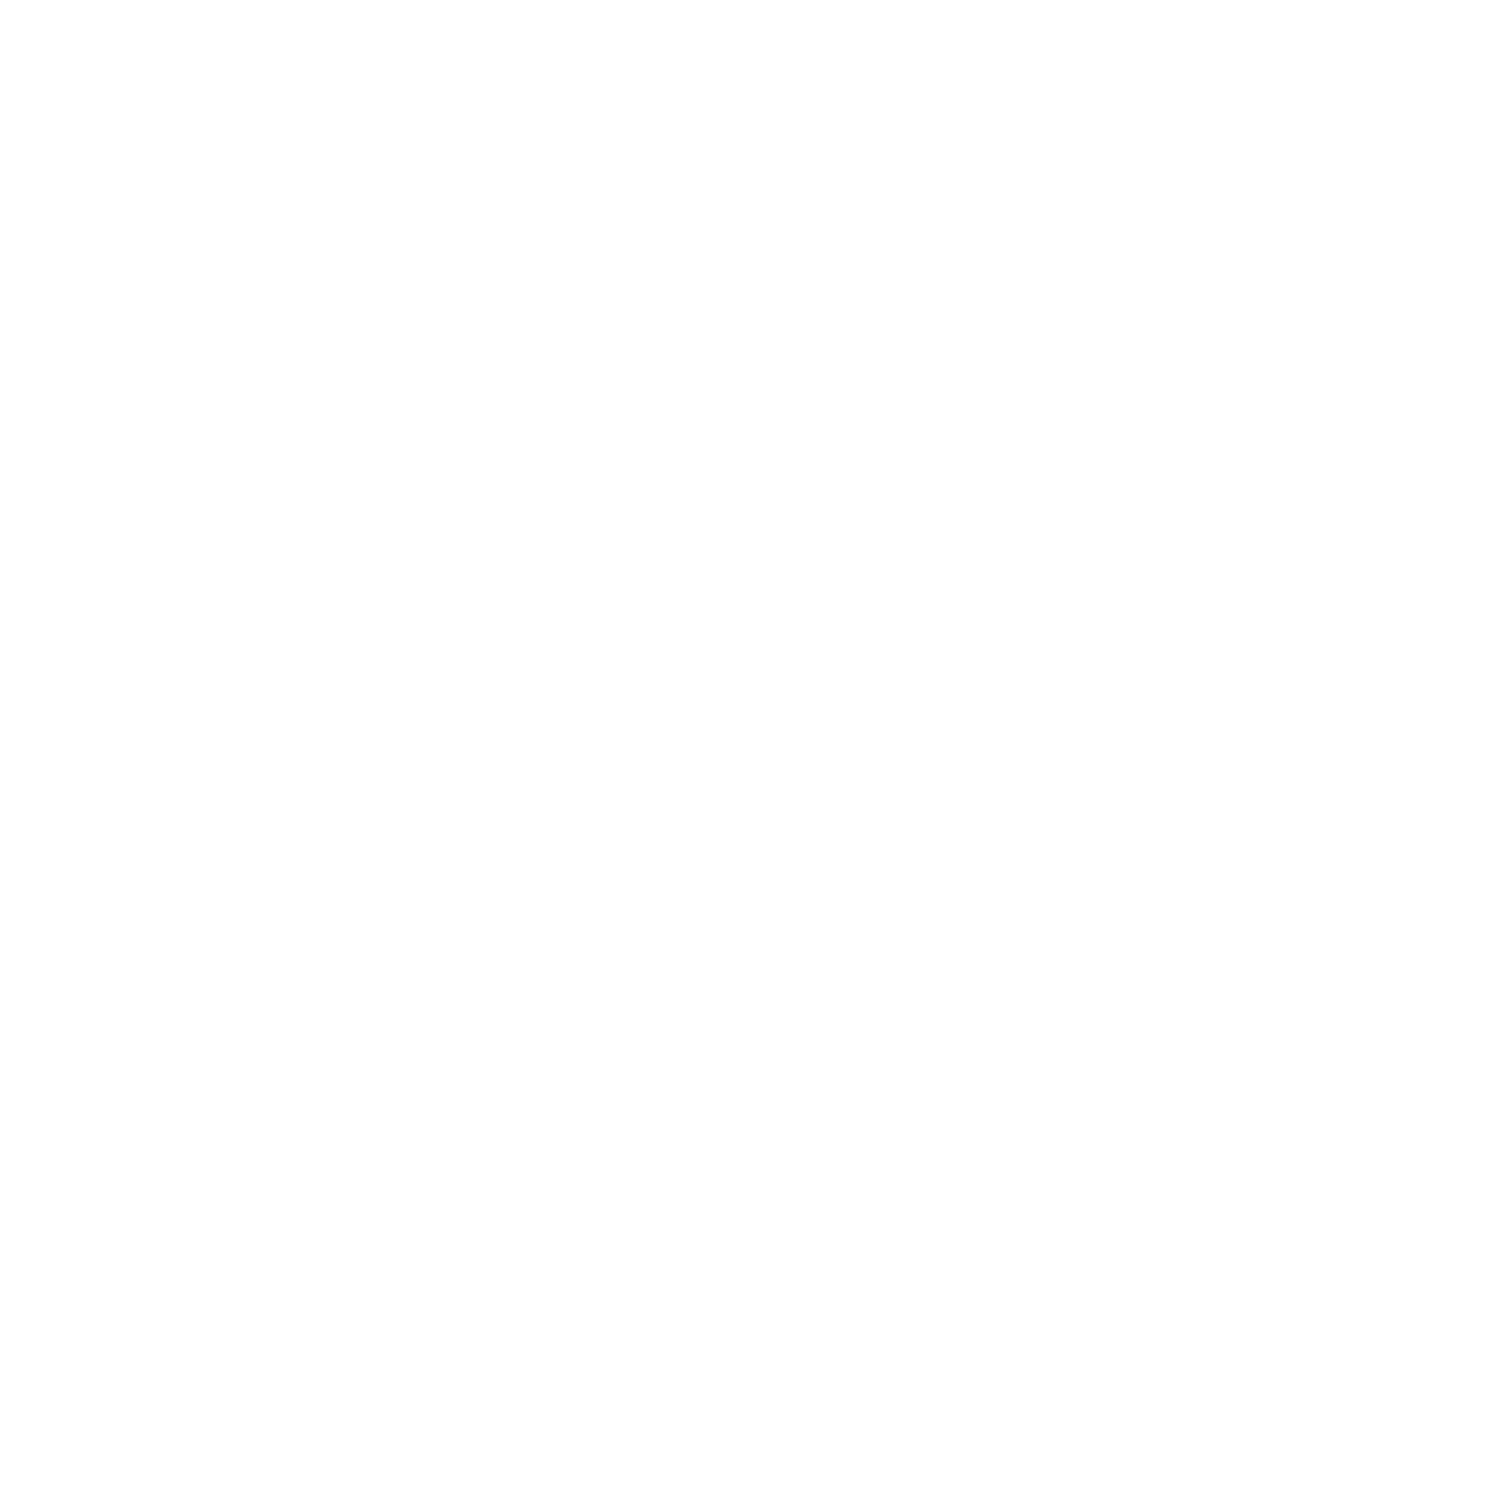

In [13]:
P.changeObserver([90*DEG,90*DEG])
P.changeStellarPosition(+30.0*DEG)
fig1,fig2,fig3=P.plotRingedPlanet(view='side',showfig=0,showstar=1)
fig1

<IPython.core.display.Javascript object>


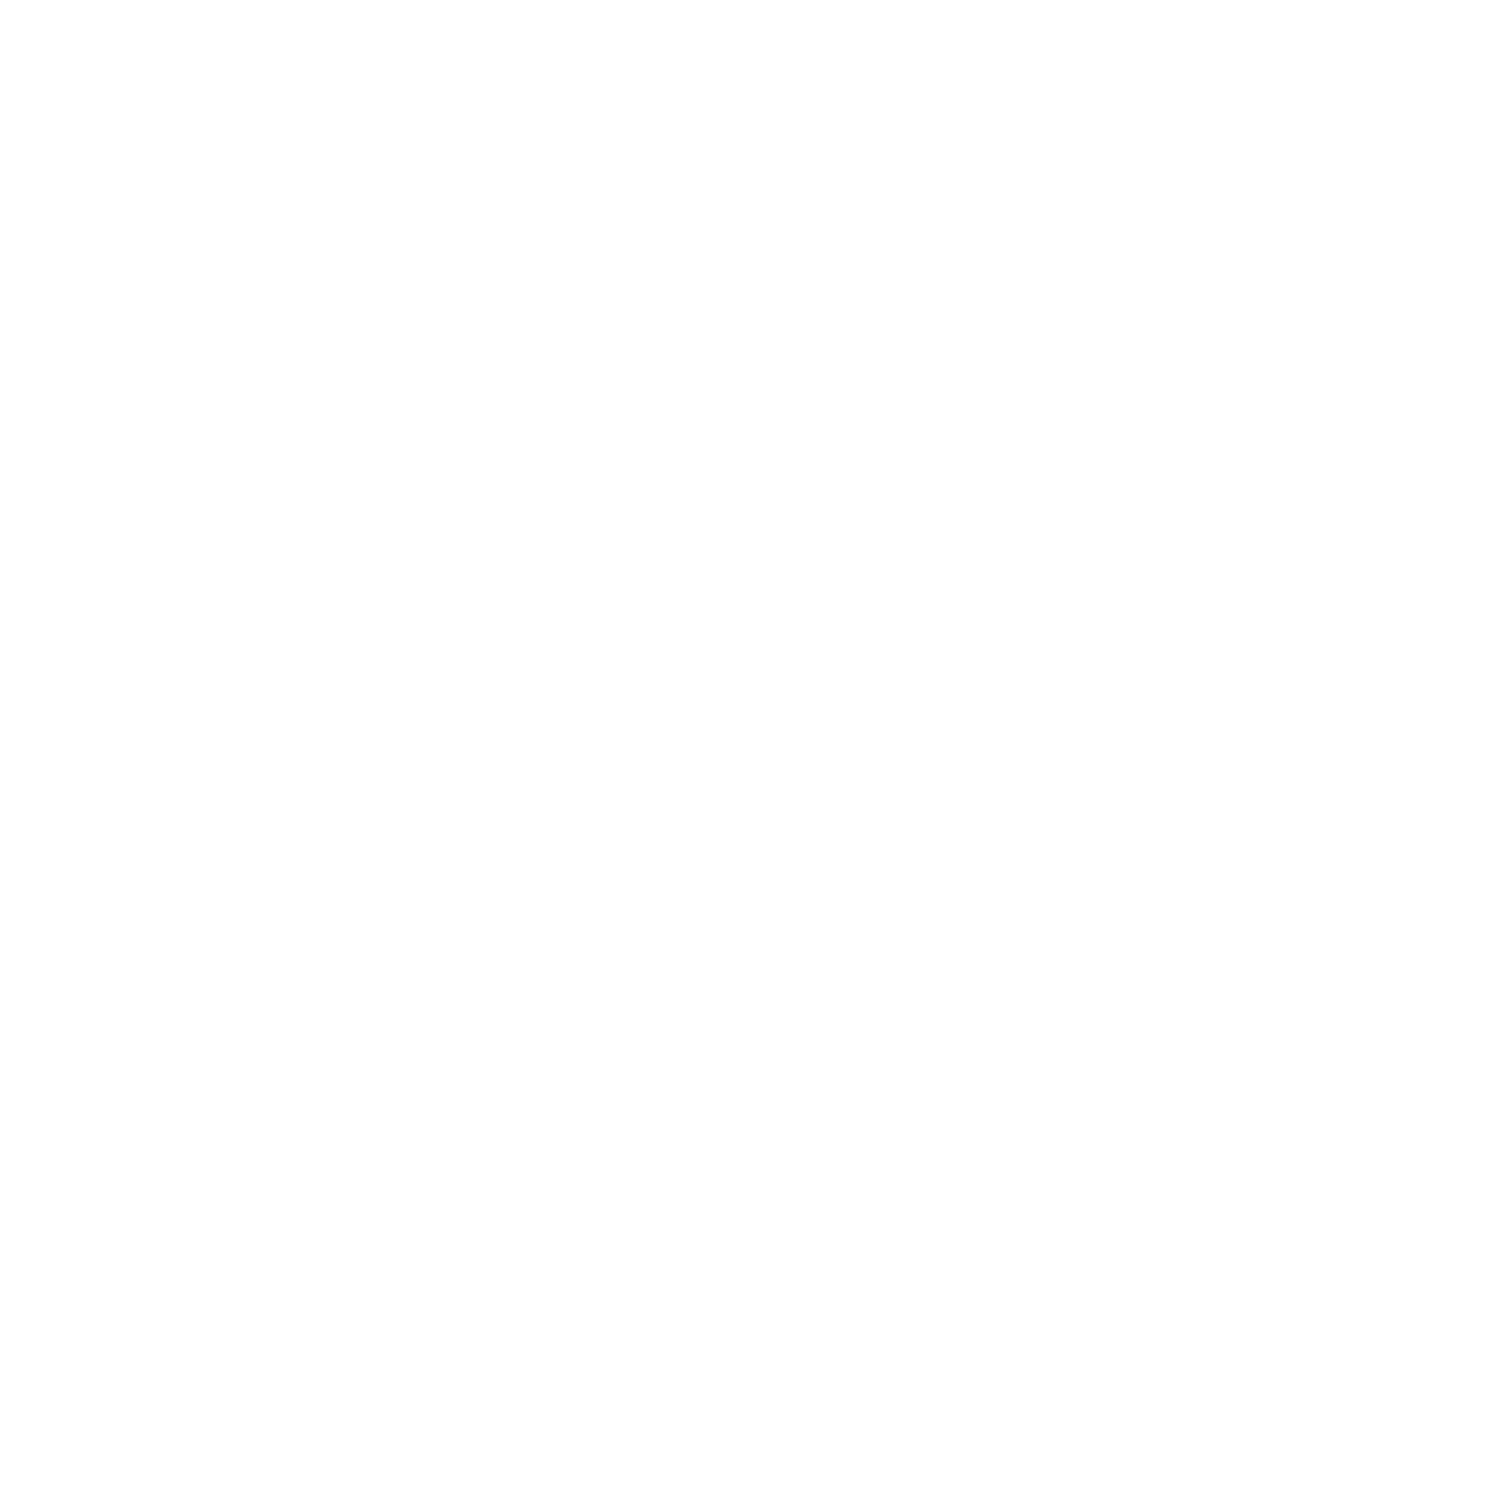

In [14]:
P.behavior["shadows"]=True
P.changeObserver([90*DEG,90*DEG])
P.changeStellarPosition(+30.0*DEG)
fig1,fig2,fig3=P.plotRingedPlanet(view='side',showfig=0,showstar=1)
fig3

--Test--

### Test

In [15]:
import unittest
from pryngles.base import *
class Test(unittest.TestCase):

    ##############################################################################
    # TEST RINGED PLANET
    ##############################################################################
    #Basic planet
    Rs=Const.Rsun/Const.au
    Rp=Const.Rsat/Const.au
    Ri=1.5
    Re=2.5
    i=30*DEG
    Ms=1
    a=0.2
    e=0.6
    Nr=10
    Np=20
    Ns=30
    Nb=50   
    #Simple planet
    P=RingedPlanet(Nr=10,Np=20,Nb=50)
    #Complete planet
    Pl=RingedPlanet(Nr=1000,Np=1000,Nb=100)
    #Light curve planet
    PL=RingedPlanet(Nr=1000,Np=1000,Nb=0)
    
    #"""                         
    #===========================================
    # TEST INITIALIZATION
    #===========================================
    def test_init_basic(self):
        #Stellar properties
        self.assertEqual(np.isclose([self.P.Mstar,self.P.mu,self.P.Rs],
                                    [self.Ms,self.Ms,1.0],
                                    rtol=1e-5).tolist(),
                         [True]*3)        

        #Planetary properties
        self.assertEqual(np.isclose([self.P.Rplanet,self.P.Rp],
                                    [self.Rp,self.Rp/self.Rs],
                                    rtol=1e-5).tolist(),
                         [True]*2)
        
        #Ring properties
        self.assertEqual(np.isclose([self.P.Rint/self.P.Rplanet,self.P.Rext/self.P.Rplanet],
                                    [self.Ri,self.Re],
                                    rtol=1e-5).tolist(),
                         [True]*2)        
        self.assertEqual(np.isclose([self.P.Ri/self.P.Rp,self.P.Re/self.P.Rp,self.P.i],
                                    [self.Ri,self.Re,self.i],
                                    rtol=1e-5).tolist(),
                         [True]*3)
        
        #Areas 
        self.assertEqual(np.isclose([self.P.Ap,self.P.As,self.P.Ar],
                                    [0.022022495411633137,3.141592653589793,0.08808998164653253],
                                    rtol=1e-5).tolist(),
                         [True]*3)
        #Orbit
        self.assertEqual(np.isclose([self.P.a,self.P.aplanet,self.P.e],
                                    [self.a,self.a/self.Rs,self.e],
                                    rtol=1e-5).tolist(),
                         [True]*3)
        self.assertEqual(np.isclose([self.P.n,self.P.T],
                                    [11.180339887498947, 0.5619851784832581],
                                    rtol=1e-5).tolist(),
                         [True]*2)

        #Orientation    
        self.assertEqual(np.isclose(self.P.M_equ2ecl.flatten().tolist(),
                                    [1.0, 0.0, 0.0, 0.0, 0.8660254037844387, 0.49999999999999994, 0.0, -0.49999999999999994, 0.8660254037844387],
                                    rtol=1e-5).tolist(),
                         [True]*9)
        self.assertEqual(np.isclose(self.P.M_ecl2equ.flatten().tolist(),
                                    [1.0, -0.0, 0.0, -0.0, 0.8660254037844387, -0.49999999999999994, -0.0, 0.49999999999999994, 0.8660254037844387],
                                    rtol=1e-5).tolist(),
                         [True]*9)

    def test_init_sampling(self):
        
        #Check number of particles in rings
        self.assertEqual(self.P.Nr,8,True)
        self.assertEqual(self.P.Nrt,108,True)

        #Check sampling coordinates
        self.assertEqual(np.isclose(np.mean(self.P.ess,axis=0).tolist(),
                                    [0.7427234173627909, 3.060789891785035],
                                    rtol=1e-5).tolist(),
                         [True]*2)
        self.assertEqual(np.isclose(np.std(self.P.rps_equ,axis=0).tolist(),
                                    [0.04835780638007535, 0.04835489501121103, 0.04827854272496943],
                                    rtol=1e-5).tolist(),
                         [True]*3)
        self.assertEqual(np.isclose(np.std(self.P.eps_equ,axis=0).tolist(),
                                    [1.8506539978100773, 0.6779827903869884],
                                    rtol=1e-5).tolist(),
                         [True]*2)
        self.assertEqual(np.isclose(np.std(self.P.rps_ecl,axis=0).tolist(),
                                    [0.04835780638007535, 0.04895307141434182, 0.04767190323759154],
                                    rtol=1e-5).tolist(),
                         [True]*3)
        self.assertEqual(np.isclose(np.std(self.P.eps_ecl,axis=0).tolist(),
                                    [1.8950869732941793, 0.6649073367239384],
                                    rtol=1e-5).tolist(),
                         [True]*2)
        self.assertEqual(np.isclose(np.std(self.P.rrs_equ,axis=0).tolist(),
                                    [0.12452129618769214, 0.12196642974111802, 0.0],
                                    rtol=1e-5).tolist(),
                         [True]*3)
        self.assertEqual(np.isclose(np.mean(self.P.ers_equ,axis=0).tolist(),
                                    [3.1335776702777403, 0.0],
                                    rtol=1e-5).tolist(),
                         [True]*2)
        self.assertEqual(np.isclose(np.std(self.P.rrs_ecl,axis=0).tolist(),
                                    [0.12452129618769214, 0.10562602656469813, 0.060983214870559],
                                    rtol=1e-5).tolist(),
                         [True]*3)
        self.assertEqual(np.isclose(np.std(self.P.ers_ecl,axis=0).tolist(),
                                    [1.868080991010684, 0.3615248816986749],
                                    rtol=1e-5).tolist(),
                         [True]*2)

        #Check facet areas
        self.assertEqual(np.isclose([self.P.afp,self.P.afr,self.P.afs],
                                    [0.0118285470250286, 0.04585692412802634, 0.10471975511965977],
                                    rtol=1e-5).tolist(),
                         [True]*3)
                         
    def test_init_observer(self):
    
        #Observer
        self.assertEqual(np.isclose([self.P.io],
                                    [self.P.i],
                                    rtol=1e-5).tolist(),
                         [True]*1)
        self.assertEqual(np.isclose(self.P.nobs_ecl.tolist(),
                                    [0,0,1],
                                    rtol=1e-5).tolist(),
                         [True]*3)
        self.assertEqual(np.isclose(self.P.nobs_equ.tolist(),
                                    [0, -0.4999999999999999, 0.8660254037844387],
                                    rtol=1e-5).tolist(),
                         [True]*3)
        
        self.assertEqual(np.isclose(self.P.M_obs2equ.flatten().tolist(),
                                    [-1.0,0,0.0,0,-0.8660254037844387,-0.5,0,-0.5,0.8660254037844387],
                                    rtol=1e-5).tolist(),
                         [True]*9)
        
        #Update observer
        self.assertEqual(np.isclose([self.P.normr,self.P.normp],
                                    [0.2401218118135148, 0.3734628539073261],
                                    rtol=1e-5).tolist(),
                         [True]*2)
        
        self.assertEqual(np.isclose(np.mean(self.P.rps_obs,axis=0).tolist(),
                                    [-0.00126286, -0.00081802, -0.00047228],
                                    rtol=1e-5).tolist(),
                         [True]*3)
        self.assertEqual(np.isclose(np.mean(self.P.rrs_obs,axis=0).tolist(),
                                    [-0.0035211684091234203, 0.00046198149704504594, 0.00026672514167958624],
                                    rtol=1e-5).tolist(),
                         [True]*3)
        self.assertEqual(np.isclose(np.mean(self.P.nps_obs,axis=0).tolist(),
                                    [-0.015083302055958628, -0.009770192582955101, -0.005640823317803534],
                                    rtol=1e-5).tolist(),
                         [True]*3)
        self.assertEqual(np.isclose([np.mean(np.linalg.norm(self.P.nps_obs,axis=1))],
                                    [1],
                                    rtol=1e-5).tolist(),
                         [True]*1)
        
    def test_init_stellar_pos(self):

        #Update stellar position
        self.assertEqual(np.isclose([self.P.rstar],
                                    [17.20751678624319],
                                    rtol=1e-5).tolist(),
                         [True]*1)
        self.assertEqual(np.isclose(self.P.rstar_ecl.tolist(),
                                    [17.20751678624319, 0.0, 0.0],
                                    rtol=1e-5).tolist(),
                         [True]*3)
        self.assertEqual(np.isclose(self.P.rstar_equ.tolist(),
                                    [17.20751678624319, 0.0, 0.0],
                                    rtol=1e-5).tolist(),
                         [True]*3)
        self.assertEqual(np.isclose(self.P.nstar_equ.tolist(),
                                    [1.0, 0.0, 0.0],
                                    rtol=1e-5).tolist(),
                         [True]*3)
        self.assertEqual(np.isclose(self.P.estar_equ.tolist(),
                                    [0.0, 0.0],
                                    rtol=1e-5).tolist(),
                         [True]*2)
        self.assertEqual(np.isclose([self.P.thetas,self.P.thetap],
                                    [0.05804884790101778,0.0048656033146136455],
                                    rtol=1e-5).tolist(),
                         [True]*2)        
        self.assertEqual(np.isclose(self.P.rstar_ecl.tolist(),
                                    [17.20751678624319, 0.0, 0.0],
                                    rtol=1e-5).tolist(),
                         [True]*3)
        self.assertEqual(np.isclose(self.P.estar_ecl.tolist(),
                                    [0.0, 0.0],
                                    rtol=1e-5).tolist(),
                         [True]*2)

        self.assertEqual(np.isclose(self.P.rstar_obs.tolist(),
                                    [-1.72075168e+01,0,0.00000000e+00],
                                    rtol=1e-5).tolist(),
                         [True]*3)
        self.assertEqual(np.isclose(self.P.nstar_obs.tolist(),
                                    [-1.0, 0.0, 0.0],
                                    rtol=1e-5).tolist(),
                         [True]*3)
                         
    def test_init_physics(self):
        #Physical properties
        self.assertEqual(np.isclose([self.P.gamma0,self.P.gammap0],
                                    [0.910080416049327,0.07957747154594767],
                                    rtol=1e-2).tolist(),
                         [True]*2)
        self.assertEqual(np.isclose([self.P.normlimb],
                                    [2.45567825755602],
                                    rtol=1e-5).tolist(),
                         [True]*1)

    def test_init_optical(self):
        #Optical factors
        self.assertEqual(np.isclose([np.std(self.P.etaps),np.mean(self.P.etars),
                                     np.std(self.P.zetaps),np.mean(self.P.zetars)],
                                    [0.2896162404111873, 0.0, 0.5693825632088421, 0.8660254037844385],
                                    rtol=1e-2).tolist(),
                         [True]*4)
        
        self.assertEqual(np.isclose([np.mean(self.P.ALps[self.P.ip])],
                                    [0.534933661599417],
                                    rtol=1e-2).tolist(),
                         [True]*1)        

        self.assertEqual(np.isclose([np.log10(np.mean(self.P.fluxips[self.P.ip])),
                                     np.log10(np.mean(self.P.afps))],
                                    [-6.213638359911997,-2.6522470205129283],
                                    rtol=1e-2).tolist(),
                         [True]*2)        

    #===========================================
    # TEST SINGLE ROUTINES
    #===========================================
    def test_incoming_stellar_flux(self):
        self.Pl.changeObserver([+0.0*DEG,90.0*DEG])
        self.Pl.changeStellarPosition(+30.0*DEG)
        self.Pl.updateOpticalFactors()
        self.assertEqual(np.isclose([(self.Pl.fluxips[:int(self.Pl.Np/3)]).sum()],
                                    [7.005543149865829e-07],
                                    rtol=1e-2).tolist(),
                         [True]*1)
        self.assertEqual(np.isclose([(self.Pl.fluxirs[:int(self.Pl.Nrt/3)]).sum()],
                                    [1.907901293374936e-06],
                                    rtol=1e-2).tolist(),
                         [True]*1)

    def test_facet_areas(self):
        self.Pl.changeObserver([+60.0*DEG,0.0*DEG])
        self.Pl.changeStellarPosition(+0.0*DEG)
        self.Pl.updateOpticalFactors()
        self.assertEqual(np.isclose([self.Pl.afps.std()],
                                    [2.542683621350747e-05],
                                    rtol=1e-2).tolist(),
                         [True]*1)
        self.assertEqual(np.isclose([self.Pl.afrs.mean()],
                                    [5.85031917e-05],
                                    rtol=1e-2).tolist(),
                         [True]*1)

    def test_update_geometrical_factors(self):
        self.Pl.changeObserver([+30.0*DEG,0.0*DEG])
        self.Pl.changeStellarPosition(+30.0*DEG)
        self.Pl.updateOpticalFactors()
        
        #Etas
        self.assertEqual(np.isclose([(self.Pl.etaps[:int(self.Pl.Np/3)]).sum()],
                                    [148.72325636637626],
                                    rtol=1e-2).tolist(),
                         [True]*1)
        self.assertEqual(np.isclose([self.Pl.etars[0]],
                                    [0.25],
                                    rtol=1e-2).tolist(),
                         [True]*1)
        #Zetas
        self.assertEqual(np.isclose([(self.Pl.zetaps[:int(self.Pl.Np/3)]).sum()],
                                    [-55.087484711441064],
                                    rtol=1e-2).tolist(),
                         [True]*1)
        self.assertEqual(np.isclose([self.Pl.zetars[0]],
                                    [0.25],
                                    rtol=1e-2).tolist(),
                         [True]*1)
    
    def test_accelerate_lambertian_albedo_ring(self):  
        self.assertEqual(np.isclose([self.P.getLambertianAlbedoRing(0.0)],
                                    [self.P._calcLambertianAlbedoRing(0.0,gammap0=self.P.gammap0,reflection_law=self.P.reflection_rings_law)],
                                    rtol=1e-2).tolist(),
                         [True]*1)
        self.assertEqual(np.isclose([self.P.getLambertianAlbedoRing(0.85)],
                                    [self.P._calcLambertianAlbedoRing(0.85,gammap0=self.P.gammap0,reflection_law=self.P.reflection_rings_law)],
                                    rtol=1e-2).tolist(),
                         [True]*1)
        self.assertEqual(np.isclose([self.P.getLambertianAlbedoRing(1.00)],
                                    [self.P._calcLambertianAlbedoRing(1.00,gammap0=self.P.gammap0,reflection_law=self.P.reflection_rings_law)],
                                    rtol=1e-2).tolist(),
                         [True]*1)

    def test_lambertian_albedos(self):
        self.Pl.changeObserver([+0.0*DEG,90.0*DEG])
        self.Pl.changeStellarPosition(+30.0*DEG)
        self.Pl.updateOpticalFactors()
        self.assertEqual(np.isclose([(self.Pl.ALps[:int(self.Pl.Np/3)]).sum()],
                                    [-181.64819153404108],
                                    rtol=1e-2).tolist(),
                         [True]*1)
        self.assertEqual(np.isclose([(self.Pl.ALrs[:int(self.Pl.Nrt/3)]).sum()],
                                    [65.4287583053232],
                                    rtol=1e-2).tolist(),
                         [True]*1)

        self.Pl.changeStellarPosition(+0.0*DEG)
        self.Pl.updateOpticalFactors()
        self.assertEqual(np.isclose([(self.Pl.ALps[:int(self.Pl.Np/3)]).sum()],
                                    [-73.40696750315567],
                                    rtol=1e-2).tolist(),
                         [True]*1)
        self.assertEqual(np.isclose([(self.Pl.ALrs[:int(self.Pl.Nrt/3)]).sum()],
                                    [-284.0],
                                    rtol=1e-2).tolist(),
                         [True]*1)

    def test_find_gamma(self):
        self.P.AS=0.0
        self.assertEqual(np.isclose([self.P._findGamma()],
                                    [0.0],
                                    rtol=1e-2).tolist(),
                         [True]*1)
        self.P.AS=0.1
        self.assertEqual(np.isclose([self.P._findGamma()],
                                    [0.341796875],
                                    rtol=1e-2).tolist(),
                         [True]*1)
        self.P.AS=0.98
        self.assertEqual(np.isclose([self.P._findGamma()],
                                    [0.9921875],
                                    rtol=1e-2).tolist(),
                         [True]*1)

    def test_find_gammap(self):
        self.P.AL=0.0
        self.assertEqual(np.isclose([self.P._findGammap()],
                                    [0.0],
                                    rtol=1e-3).tolist(),
                         [True]*1)
        self.P.AL=0.1
        self.assertEqual(np.isclose([self.P._findGammap()],
                                    [0.0159149169921875],
                                    rtol=1e-3).tolist(),
                         [True]*1)
        self.P.AL=0.98
        self.assertEqual(np.isclose([self.P._findGammap()],
                                    [0.1558837890625],
                                    rtol=1e-3).tolist(),
                         [True]*1)
    
    def test_accelerate_lambertian_albedo_planet(self):
        self.assertEqual(np.isclose([self.P.getLambertianAlbedoPlanet(0.0)],
                                    [self.P._calcLambertianAlbedoPlanet(0.0)],
                                    rtol=1e-2).tolist(),
                         [True]*1)
        self.assertEqual(np.isclose([self.P.getLambertianAlbedoPlanet(0.85)],
                                    [self.P._calcLambertianAlbedoPlanet(0.85)],
                                    rtol=1e-2).tolist(),
                         [True]*1)
        self.assertEqual(np.isclose([self.P.getLambertianAlbedoPlanet(1.00)],
                                    [self.P._calcLambertianAlbedoPlanet(1.00)],
                                    rtol=1e-2).tolist(),
                         [True]*1)

    def test_lambertian_albedo_planet(self):
        self.P.updatePhysicalProperties(dict(AS=0.3))
        self.assertEqual(np.isclose([self.P._calcLambertianAlbedoPlanet(0.0),
                                     self.P._calcLambertianAlbedoPlanet(0.3),
                                     self.P._calcLambertianAlbedoPlanet(0.6),
                                     self.P._calcLambertianAlbedoPlanet(1.0),
                                     ],
                                    [0.5039089384890072, 0.3713696943832471, 0.3044823163855821, 0.24720433837777744],
                                    rtol=1e-3).tolist(),
                         [True]*4)

    def test_spherical_albedo(self):
        self.assertEqual(np.isclose([self.P._calcSphericalAlbedo(0.0),
                                     self.P._calcSphericalAlbedo(0.5),
                                     self.P._calcSphericalAlbedo(1.0)
                                    ],
                                    [0,0.14646627099560008,1],
                                    rtol=1e-3).tolist(),
                         [True]*3)

    def test_reflection_coefficient(self):
        self.assertEqual(np.isclose([self.P._calcReflectionCoefficient(0.1,0.1,gamma0=1),
                                     self.P._calcReflectionCoefficient(0.8,1.0,gamma0=1)],
                                    [1.9437612500000003, 1.0311283333333332],
                                    rtol=1e-5).tolist(),
                         [True]*2)
    
    def test_diffuse_reflection_function(self):
        self.assertEqual(np.isclose(self.P.fint(0.7,[0.1,0.5,0.7]).flatten().tolist(),
                                    [1.113, 1.318, 1.378],
                                    rtol=1e-5).tolist(),
                         [True]*3)

    def test_activity(self):
        self.Pl.changeObserver([+30.0*DEG,0.0*DEG])
        #Normal up
        self.Pl.changeStellarPosition(60.0*DEG)
        self.assertEqual([self.Pl.ap.sum(),self.Pl.ar.sum()],[329,690],[True]*2)
        #Normal down
        self.Pl.changeStellarPosition(260.0*DEG)        
        self.assertEqual([self.Pl.ap.sum(),self.Pl.ar.sum()],[175,677],[True]*2)
        #Transit
        lamb=+210.0*DEG
        self.Pl._updateStellarPosition(lamb)
        self.Pl.changeStellarPosition(lamb+1*self.Pl.thetas)        
        self.assertEqual([self.Pl.ap.sum(),self.Pl.ar.sum()],[270,683],[True]*2)
        #Occultation
        lamb=+30.0*DEG
        self.Pl._updateStellarPosition(lamb)
        self.Pl.changeStellarPosition(lamb+1*self.Pl.thetas)        
        self.assertEqual([self.Pl.ap.sum(),self.Pl.ar.sum()],[230,384],[True]*2)
        
    def test_transitability(self):
        self.Pl.changeObserver([+30.0*DEG,0.0*DEG])
        #Transit
        lamb=+210.0*DEG
        self.Pl._updateStellarPosition(lamb)
        self.Pl.changeStellarPosition(lamb+1*self.Pl.thetas)
        self.assertEqual([self.Pl.tp.sum(),self.Pl.tr.sum()],[278,446],[True]*2)
        #Occultation
        lamb=+30.0*DEG
        self.Pl._updateStellarPosition(lamb)
        self.Pl.changeStellarPosition(lamb+1*self.Pl.thetas)
        self.assertEqual([self.Pl.cp.sum(),self.Pl.cr.sum()],[216,405],[True]*2)

    def test_visibility(self):
        self.Pl.changeStellarPosition(45.0*DEG)
        self.Pl.changeObserver([30.0*DEG,0.0*DEG])
        self.Pl._updateVisibility()
        self.assertEqual([self.Pl.vp.sum(),self.Pl.vr.sum()],[435,723],[True]*2)
        self.assertEqual([self.Pl.vpo.sum(),self.Pl.vro.sum()],[503,852],[True]*2)
    
    def test_shadow(self):
        self.Pl.changeStellarPosition(45.0*DEG)
        self.Pl._resetIllumination()
        self.Pl._updatePlanetShadow(epos=self.Pl.estar_equ,mask=self.Pl.sp)
        self.Pl._updateRingsShadow(epos=self.Pl.estar_equ,mask=self.Pl.sr)
        self.assertEqual(self.Pl.sp.sum(),101,True)        
        self.assertEqual(self.Pl.sr.sum(),103,True)        

    def test_update_illumination(self):
        self.Pl.changeObserver([+0.0*DEG,+90.0*DEG])
        self.Pl.changeStellarPosition(45.0*DEG)
        self.assertEqual([self.Pl.ip.sum(),self.Pl.np.sum()],[401,416],[True]*2)
        self.assertEqual([self.Pl.ir.sum(),self.Pl.nr.sum()],[749,749],[True]*2)
        self.Pl.changeStellarPosition(245.0*DEG)
        self.assertEqual([self.Pl.ip.sum(),self.Pl.np.sum()],[407,83],[True]*2)
        self.assertEqual([self.Pl.ir.sum(),self.Pl.nr.sum()],[0,0],[True]*2)
    
    def test_update_sampling_observer(self):
        self.P._updateObserver([40.0*DEG,50.0*DEG])
        self.Pl.changeStellarPosition(0.0*DEG)
        self.P._updateSamplingObserver()
        
        self.assertEqual(np.isclose(np.mean(self.P.rps_obs,axis=0).tolist(),
                                    [-0.00018511380521670282, -0.0014474464466447522, 0.0005980322218867171],
                                    rtol=1e-5).tolist(),
                         [True]*3)
        self.assertEqual(np.isclose(np.mean(self.P.rrs_obs,axis=0).tolist(),
                                    [-0.002617261783639338, -0.0016673773470304288, 0.0017472806611232988],
                                    rtol=1e-5).tolist(),
                         [True]*3)
        self.assertEqual(np.isclose(np.mean(self.P.nps_obs,axis=0).tolist(),
                                    [-0.0022109579383547294, -0.01728797702476117, 0.007142763268382224],
                                    rtol=1e-5).tolist(),
                         [True]*3)
        self.assertEqual(np.isclose([np.mean(np.linalg.norm(self.P.nps_obs,axis=1))],
                                    [1],
                                    rtol=1e-5).tolist(),
                         [True]*1)

        self.assertEqual(np.isclose([self.P.normr,self.P.normp],
                                    [0.2401218118135148, 0.35791377055410756],
                                    rtol=1e-5).tolist(),
                         [True]*2)

    def test_update_observer(self):
        self.P._updateObserver([40.0*DEG,50.0*DEG])
        #Normal to observer
        self.assertEqual(np.isclose(self.P.nobs_ecl.tolist(),
                                    [0.4924038765061041, 0.4131759111665348, 0.766044443118978],
                                    rtol=1e-5).tolist(),
                         [True]*3)

        #Transformation matrix
        self.assertEqual(np.isclose(self.P.M_obs2equ.flatten().tolist(),
                                    [-0.6427876096865393, -0.5868240888334654, 0.49240387650610407, 0.6634139481689385, -0.7478280708194912, -0.025201386257487385, 0.383022221559489, 0.3104684609733674, 0.8700019037522058],
                                    rtol=1e-5).tolist(),
                         [True]*9)        

        self.assertEqual(np.isclose([self.P.io*RAD],
                                    [29.541139271144967],
                                    rtol=1e-5).tolist(),
                         [True]*1)
        self.assertEqual(np.isclose(self.P.nobs_equ.tolist(),
                                    [0.4924038765061041, -0.0252013862574873, 0.8700019037522058],
                                    rtol=1e-5).tolist(),
                         [True]*3)

    def test_update_stellar_position(self):
        #Update by lambda
        self.P.changeObserver([0.0*DEG,90.0*DEG])
        self.P._updateStellarPosition(30.0*DEG)
        self.assertEqual(np.isclose([self.P.lamb*RAD,self.P.t,self.P.M*RAD,self.P.E*RAD,self.P.f*RAD],
                                    [29.999999999999996, 0.009698127996429691, 6.212487824211714, 
                                     15.261480424860114, 29.999999999999996],
                                    rtol=1e-5).tolist(),
                         [True]*5)
        
        #Update by time
        self.P._updateStellarPosition(0.25*self.P.T,kepler=True)
        self.assertEqual(np.isclose([self.P.lamb*RAD,self.P.t/self.P.T,self.P.M*RAD,self.P.E*RAD,self.P.f*RAD],
                                    [147.6875974348218, 0.25, 90.0, 119.82432332714434, 147.6875974348218],
                                    rtol=1e-5).tolist(),
                         [True]*5)        
        
        self.assertEqual(np.isclose([self.P.rstar],
                                    [55.855830977897924],
                                    rtol=1e-5).tolist(),
                         [True]*1)
        self.assertEqual(np.isclose(self.P.rstar_ecl.tolist(),
                                    [-47.20634019984805, 29.856913758252233, 0.0],
                                    rtol=1e-5).tolist(),
                         [True]*3)
        self.assertEqual(np.isclose(self.P.rstar_equ.tolist(),
                                    [-47.20634019984805, 25.856845793247555, 14.928456879126115],
                                    rtol=1e-5).tolist(),
                         [True]*3)
        self.assertEqual(np.isclose(self.P.nstar_equ.tolist(),
                                    [-0.8451461445185111, 0.46292115506220066, 0.267267653488734],
                                    rtol=1e-5).tolist(),
                         [True]*3)
        self.assertEqual(np.isclose(spy.vnorm(self.P.nstar_equ),
                                    [1],
                                    rtol=1e-5).tolist(),
                         [True]*1)
        self.assertEqual(np.isclose(self.P.estar_equ.tolist(),
                                    [2.640485489653583, 0.2705564165918936],
                                    rtol=1e-5).tolist(),
                         [True]*2)        
        self.assertEqual(np.isclose([self.P.thetas,self.P.thetap],
                                    [0.017901321332265366, 0.0014989580720400028],
                                    rtol=1e-5).tolist(),
                         [True]*2)
        self.assertEqual(np.isclose(self.P.rstar_ecl.tolist(),
                                    [-47.20634019984805, 29.856913758252233, 0.0],
                                    rtol=1e-5).tolist(),
                         [True]*3)
        self.assertEqual(np.isclose(self.P.estar_ecl.tolist(),
                                    [2.577634839597572, 0.0],
                                    rtol=1e-5).tolist(),
                         [True]*2)
        self.assertEqual(np.isclose(self.P.rstar_obs.tolist(),
                                    [29.85691375825223, 47.20634019984805, 0.0],
                                    rtol=1e-5).tolist(),
                         [True]*3)
        self.assertEqual(np.isclose(self.P.nstar_obs.tolist(),
                                    [0.534535306977468, 0.8451461445185111, 0.0],
                                    rtol=1e-5).tolist(),
                         [True]*3)        

    #===========================================
    # TEST LIGHT CURVE
    #===========================================
    def test_facets_onsky_ring(self):
        self.PL.changeObserver([+30.0*DEG,0.0*DEG])
        self.PL.changeStellarPosition(+60.0*DEG)
        
        cond=(self.PL.ar[self.PL.irn])*(self.PL.nr[self.PL.irn])*(~self.PL.tr[self.PL.irn])*(~self.PL.cr[self.PL.irn])
        isel=np.arange(self.PL.Nr)[cond][-1]
        rr=self.PL.rrs_equ[isel]
        msp,rijs,etaijs,zetaijs=self.PL._getFacetsOnSky(rr,observing_body="ring")
        self.assertEqual(msp.sum(),87014,True)

    def test_facets_onsky_planet(self):
        self.PL.changeObserver([+30.0*DEG,0.0*DEG])
        self.PL.changeStellarPosition(+60.0*DEG)
        
        cond=(self.PL.ap)*(self.PL.np)*(~self.PL.tp)*(~self.PL.cp)
        isel=np.arange(self.PL.Np)[cond][0]
        rp=self.PL.rps_equ[isel]
        msp,rijs,etaijs,zetaijs=self.PL._getFacetsOnSky(rp,observing_body="planet")
        self.assertEqual(msp.sum(),75071,True)

    def test_reflected_light(self):
        self.PL.changeObserver([+30.0*DEG,0.0*DEG])
        self.PL.changeStellarPosition(+60.0*DEG)
        self.PL.updateOpticalFactors()
        self.PL.updateDiffuseReflection()
        self.assertEqual(np.isclose([self.PL.Rip.sum(),self.PL.Rir.sum()],
                                    [8.950665510705045e-07, 6.85930409233611e-07],
                                    rtol=1e-5).tolist(),
                         [True]*2)        

    def test_transit(self):
        self.PL.changeObserver([+30.0*DEG,0.0*DEG])
        lamb=+210.0*DEG
        self.PL._updateStellarPosition(lamb)
        self.PL.changeStellarPosition(lamb+1*self.PL.thetas)
        self.PL.updateOpticalFactors()
        self.PL.updateTransit()
        self.assertEqual(np.isclose([self.PL.Tip.sum(),self.PL.Tir.sum()],
                                    [0.002664218155669836, 0.002138634697416637],
                                    rtol=1e-3).tolist(),
                         [True]*2)                                       

    def test_shining_light(self):
        self.PL.changeObserver([+30.0*DEG,0.0*DEG])
        self.PL.changeStellarPosition(+60.0*DEG)
        self.PL.updateOpticalFactors()
        self.PL.updateShine()
        self.assertEqual(np.isclose([self.PL.Sip.sum(),self.PL.Sir.sum()],
                                    [1.688935266258278e-08,1.0324347642389317e-08],
                                    rtol=1e-5).tolist(),
                         [True]*2)            
    #"""
    def blank():pass

<IPython.core.display.Javascript object>

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
if __name__=="__main__":
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

...............................
----------------------------------------------------------------------
Ran 31 tests in 1.388s

OK


--End--

## Convert

In [27]:
%%javascript
IPython.notebook.kernel.execute('FILE=\"' + IPython.notebook.notebook_name + '\"')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [36]:
!make -C ../.. DEVFILES=pryngles/dev/{FILE} convert

Converting iPython Notebooks...
Analysing file pryngles-base.ipynb:
	Directory: ./pryngles
	Filename: base
	Target object: ./pryngles/base.py
	Converting from ipynb pryngles/dev/pryngles-base.ipynb to python ./pryngles/base.py...
	Processing magic commands...
	Triming end...
	Triming test...
	Adding header...
	Creating test file ./pryngles/tests/test-base.py...
Completed.


In [23]:
# Converted

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


--Debugging--

<IPython.core.display.Javascript object>


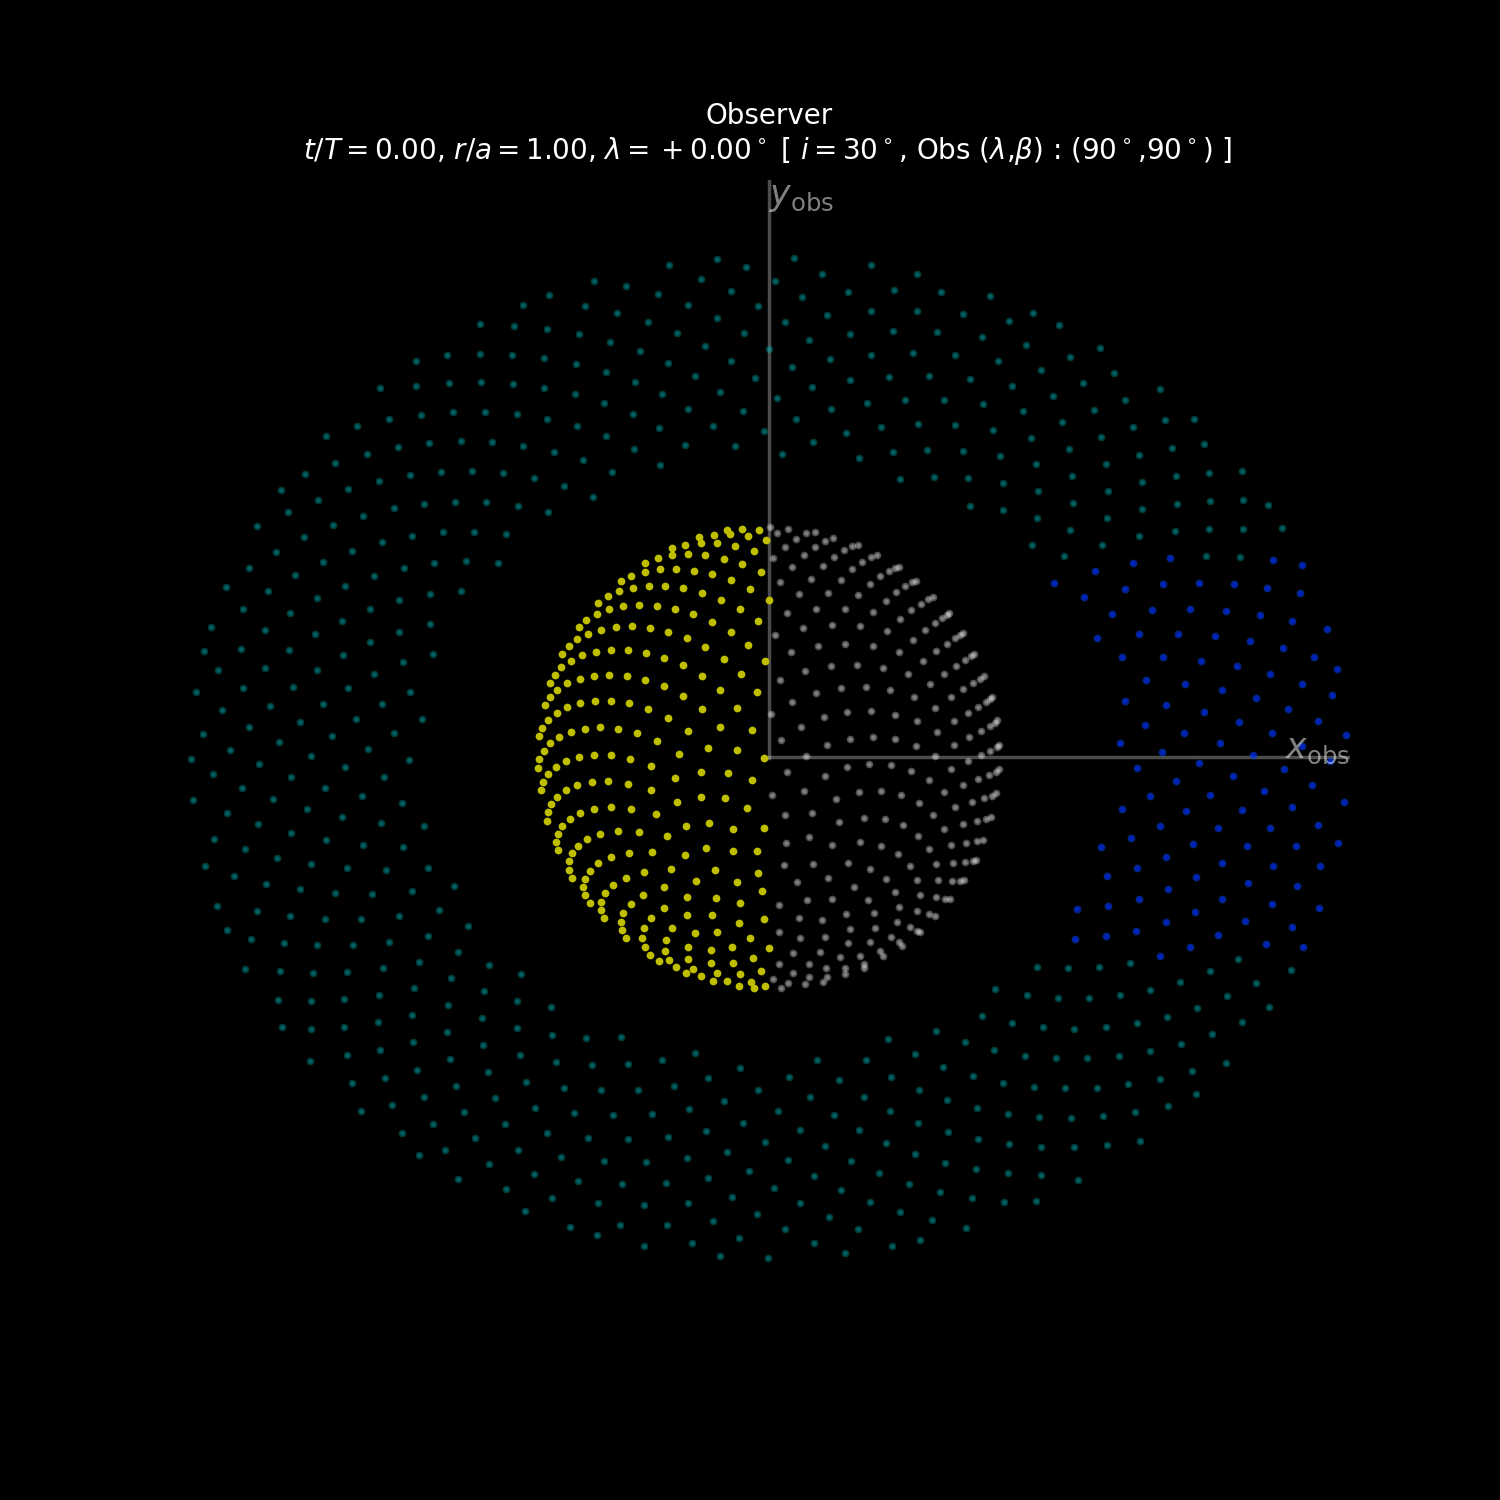

In [24]:
P.changeObserver([90*DEG,90*DEG])
P.changeStellarPosition(+0.0*DEG)
fig1,fig2,fig3=P.plotRingedPlanet(view='top',showfig=0,showstar=1)
fig2